In [1]:
import sys
#sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot4/lib/python3.7/site-packages')
sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages')
print ( sys.path )

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import mplhep
from matplotlib.colors import LogNorm
from joblib import dump, load
plt.style.use(mplhep.style.CMS)

['/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/python', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib', '', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python38.zip', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python3.8', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python3.8/lib-dynload', '/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/IPython/extensions', '/scratch/antoniov/.ipython']


In [2]:
# run_ranges_periods, df_run_ranges, fiducial_cuts, fiducial_cuts_all, aperture_period_map, aperture_parametrisation, check_aperture, get_data, process_data_protons_multiRP
from processing import *

save_figures = False

# test_sample_ratio = 0.40

run_tables = False

Welcome to JupyROOT 6.22/06
{'2017B': 2.360904801, '2017C1': 5.313012839, '2017C2': 3.264135878, '2017D': 4.074723964, '2017E': 8.958810514, '2017F1': 1.708478656, '2017F2': 7.877903151, '2017F3': 3.632463163}
Luminosity: 37.190432966


### Event selection

In [3]:
def select_events( df_events ):
#     label_jet_ = "_nom"
#     label_muon_ = "_nom"
#     label_WLep_ = "_nom"
#     label_WW_ = "_nom"
    label_jet_ = "_jes_up"
    label_muon_ = "_nom"
    label_WLep_ = "_nom"
    label_WW_ = "_jes_up"
    
    df_events.loc[ :, "deltaPhi_jet_muon"] = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "muon0_phi"] )
    msk_dphi_ = ( df_events.loc[ :, "deltaPhi_jet_muon"] < -np.pi )
    df_events.loc[ :, "deltaPhi_jet_muon"].loc[ msk_dphi_ ] = df_events.loc[ :, "deltaPhi_jet_muon"].loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( df_events.loc[ :, "deltaPhi_jet_muon"] >= np.pi )
    df_events.loc[ :, "deltaPhi_jet_muon"].loc[ msk_dphi_ ] = df_events.loc[ :, "deltaPhi_jet_muon"].loc[ msk_dphi_ ] - 2*np.pi
    
    df_events.loc[ :, "deltaEta_jet_muon"] = ( df_events.loc[ :, "jet0_eta"] - df_events.loc[ :, "muon0_eta"] )
    df_events.loc[ :, "deltaR_jet_muon"] = np.sqrt( ( df_events.loc[ :, "deltaPhi_jet_muon"] ) ** 2 +
                                                    ( df_events.loc[ :, "deltaEta_jet_muon"] ) ** 2 )
    
    df_events.loc[ :, "deltaPhi_jet_met"] = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "met_phi"] )
    msk_dphi_ = ( df_events.loc[ :, "deltaPhi_jet_met"] < -np.pi )
    df_events.loc[ :, "deltaPhi_jet_met"].loc[ msk_dphi_ ] = df_events.loc[ :, "deltaPhi_jet_met"].loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( df_events.loc[ :, "deltaPhi_jet_met"] >= np.pi )
    df_events.loc[ :, "deltaPhi_jet_met"].loc[ msk_dphi_ ] = df_events.loc[ :, "deltaPhi_jet_met"].loc[ msk_dphi_ ] - 2*np.pi
    
    df_events.loc[ :, "deltaPhi_jet_Wlep"] = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "WLeptonicPhi"] )
    msk_dphi_ = ( df_events.loc[ :, "deltaPhi_jet_Wlep"] < -np.pi )
    df_events.loc[ :, "deltaPhi_jet_Wlep"].loc[ msk_dphi_ ] = df_events.loc[ :, "deltaPhi_jet_Wlep"].loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( df_events.loc[ :, "deltaPhi_jet_Wlep"] >= np.pi )
    df_events.loc[ :, "deltaPhi_jet_Wlep"].loc[ msk_dphi_ ] = df_events.loc[ :, "deltaPhi_jet_Wlep"].loc[ msk_dphi_ ] - 2*np.pi

    df_events.loc[ :, "jet0_tau21" ] = df_events.loc[ :, "jet0_tau2"] / df_events.loc[ :, "jet0_tau1"]
    
    df_events.loc[ :, "xiCMS_45" ] = ( 1. / 13000 ) * ( df_events.loc[ :, "WLeptonicPt" + label_WLep_ ] * np.exp( df_events.loc[ :, "WLeptonicEta" ] ) +
                                                        df_events.loc[ :, "jet0_pt" + label_jet_ ] * np.exp( df_events.loc[ :, "jet0_eta" ] ) )
    df_events.loc[ :, "xiCMS_56" ] = ( 1. / 13000 ) * ( df_events.loc[ :, "WLeptonicPt" + label_WLep_ ] * np.exp( -df_events.loc[ :, "WLeptonicEta" ] ) +
                                                        df_events.loc[ :, "jet0_pt" + label_jet_ ] * np.exp( -df_events.loc[ :, "jet0_eta" ] ) )

    df_events.loc[ :, "R_MWW_MX" + label_WW_ ] = ( df_events.loc[ :, "MWW" + label_WW_ ] / df_events.loc[ :, "MX" ] )
    df_events.loc[ :, "Diff_YWW_YX" + label_WW_ ] = ( df_events.loc[ :, "YWW" + label_WW_ ] - df_events.loc[ :, "YX" ] )
    
    msk_All_ = np.full( df_events.shape[0], True, dtype=bool )
    msk_muon_ = ( ( df_events.loc[ :, "muon0_pt" + label_muon_ ] >= 50.0 ) &
                  ( np.abs( df_events.loc[ :, "muon0_eta"] ) <= 2.4 ) & 
                  ( df_events.loc[ :, "muon0_iso"] <= 0.10 ) )
    msk_jet_ = ( ( df_events.loc[ :, "jet0_pt" + label_jet_] >= 200.0 ) &
                 ( np.abs( df_events.loc[ :, "jet0_eta"] ) <= 2.4 ) )
    msk_jet_muon_ = ( df_events.loc[ :, "deltaR_jet_muon"] >= np.pi/2 )
    msk_met_ = ( df_events.loc[ :, "met"] >= 40.0 )
    msk_jet_met_ = ( np.abs( df_events.loc[ :, "deltaPhi_jet_met"] ) >= 2.0 )
    msk_pruned_mass_ = ( ( df_events.loc[ :, "jet0_corrmass" + label_jet_] >= 50.0 ) &
                         ( df_events.loc[ :, "jet0_corrmass" + label_jet_] <= 110.0 ) )
    msk_tau21_       = ( df_events.loc[ :, "jet0_tau21"] <= 0.60 )
    msk_bjet_veto_   = ( df_events.loc[ :, "num_bjets_ak4"] == 0 )
#     msk_xiCMS_ = msk_All_.copy()
    msk_xiCMS_       = ( ( df_events.loc[ :, "xiCMS_45" ] <= 0.20 ) & ( df_events.loc[ :, "xiCMS_56" ] <= 0.20 ) )
    msk_Wlep_ = ( df_events.loc[ :, "WLeptonicPt" + label_WLep_ ] >= 200.0 )
    msk_jet_Wlep_ = ( np.abs( df_events.loc[ :, "deltaPhi_jet_Wlep"] ) >= 2.5 )
#     msk_MWW_ = ( df_events.loc[ :, "recoMWW"] >= 500.0 )
    msk_MWW_ = ( df_events.loc[ :, "MWW" + label_WW_ ] >= 500.0 )
    msk_extra_tracks_ = ( df_events.loc[ :, "pfcand_nextracks" ] <= 4 )
#     msk_extra_tracks_ = ( df_events.loc[ :, "pfcand_nextracks" ] <= 999 )
    
    masks_ = [ msk_All_, msk_muon_, msk_jet_, msk_jet_muon_, msk_met_, msk_jet_met_,
               msk_pruned_mass_, msk_tau21_, msk_bjet_veto_, msk_xiCMS_,
               msk_Wlep_, msk_jet_Wlep_, msk_MWW_, msk_extra_tracks_ ]
    selection_keys_ = [ "All", "Muon", "Jet", "Jet_Muon", "MET", "Jet_MET",
                        "PrunedMass", "Tau21", "BJet_Veto", "Xi_CMS",
                        "WLeptonic", "Jet_WLeptonic", "MWW", "ExtraTracks" ]
    selections_ = {}
    msk_ = masks_[ 0 ].copy()
    for idx_, key_ in enumerate( selection_keys_ ):
        msk_ = msk_ & masks_[ idx_ ]
        selections_[ key_ ] = np.sum( msk_ )
        
    df_events = df_events.loc[ msk_ ]
    
    return df_events, selection_keys_, selections_

### Signal

In [4]:
#label = "GGToWW-AQGC-test-A0W1e-6"
#label = "GGToWW-AQGC-test-A0W2e-6"
#label = "GGToWW-AQGC-test-A0W5e-6"
labels_signals = [ "GGToWW-AQGC-A0W1e-6", "GGToWW-AQGC-A0W2e-6", "GGToWW-AQGC-A0W5e-6" ]

# fileNames_signal = [
#     #"output-GGToWW-AQGC-test-A0W1e-6.h5"
#     #"output-GGToWW-AQGC-test-A0W2e-6.h5"
#     "output-GGToWW-AQGC-test-A0W5e-6.h5"
# ]
fileNames_signals = {
    "GGToWW-AQGC-A0W1e-6": [ "output-GGToWW-AQGC-A0W1e-6.h5" ],
    "GGToWW-AQGC-A0W2e-6": [ "output-GGToWW-AQGC-A0W2e-6.h5" ],
    "GGToWW-AQGC-A0W5e-6": [ "output-GGToWW-AQGC-A0W5e-6.h5" ]
    }

df_counts_signals = {}
df_signals_protons_multiRP_index = {}
df_signals_protons_multiRP_events = {}

for label_ in labels_signals:
    import time
    print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
    time_s_ = time.time()

    #df_counts_signal, df_protons_multiRP_signal, df_protons_singleRP_signal, df_ppstracks_signal = 4 * [None]
    #df_protons_multiRP_signal_index, df_protons_multiRP_signal_events, df_ppstracks_signal_index = 3 * [None]

    if run_tables:
        with pd.HDFStore( "reduced-data-store-{}.h5".format( label_ ), complevel=5 ) as store_:

            df_counts_signal_, df_protons_multiRP_signal_, df_protons_singleRP_signal_, df_ppstracks_signal_ = get_data( fileNames_signals[ label_ ] )
            df_protons_multiRP_signal_index_, df_protons_multiRP_signal_events_, df_ppstracks_signal_index_ = process_data_protons_multiRP( df_protons_multiRP_signal_, df_ppstracks_signal_, apply_fiducial=True, within_aperture=True, select_2protons=False, runOnMC=True )

            store_[ "counts" ] = df_counts_signal_
            store_[ "protons_multiRP"] = df_protons_multiRP_signal_index_
            store_[ "events_multiRP" ] = df_protons_multiRP_signal_events_
    
    with pd.HDFStore( "reduced-data-store-{}.h5".format( label_ ), 'r' ) as store_:
        df_counts_signals[ label_ ] = store_[ "counts" ]
        df_signals_protons_multiRP_index[ label_ ] = store_[ "protons_multiRP" ]
        df_signals_protons_multiRP_events[ label_ ] = store_[ "events_multiRP" ]

    time_e_ = time.time()
    print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2021/05/07 16:36:09
Total time elapsed: 0
2021/05/07 16:36:09
Total time elapsed: 0
2021/05/07 16:36:10
Total time elapsed: 1


In [5]:
label_ = "GGToWW-AQGC-A0W1e-6"
# df_signals_protons_multiRP_index[ label_ ]
df_signals_protons_multiRP_index[ label_ ][ [ 'run_mc', 'crossingAngle', 'period', 'within_aperture' ] ]

run_mc  crossingAngle  period  within_aperture
run lumiblock event  slice                                                
1   2266      226549 0      302030          120.0   2017D             True
              226551 0      305965          120.0  2017F3             True
                     0      305965          120.0  2017F3             True
    2267      226605 0      305178          120.0  2017F2             True
              226690 0      299337          120.0  2017C1             True
    2268      226716 0      305178          150.0  2017F2             True
              226773 0      303435          150.0   2017E             True
    2270      226932 0      297020          130.0   2017B             True
                     0      297020          130.0   2017B             True
    2273      227227 0      305178          130.0  2017F2             True
                     0      305178          130.0  2017F2             True
    2274      227321 0      299337          150.0  2017C1             True
              227328 0      299337          150.0  2017C1             True
              227324 0      303435          150.0   2017E             True
    2275      227457 0      303435          150.0   2017E             True
                     0      303435          150.0   2017E             True
    2276      227546 0      300806          140.0  2017C2             True
                     0      300806          140.0  2017C2             True
              227579 0      303435          140.0   2017E             True
                     0      303435          140.0   2017E             True
    2277      227611 0      299337          130.0  2017C1             True
              227610 0      300806          130.0  2017C2             True
              227661 0      302030          130.0   2017D             True
    2278      227745 0      303435          150.0   2017E             True
    2279      227825 0      299337          130.0  2017C1             True
              227868 0      303435          130.0   2017E             True
    2280      227969 0      303435          120.0   2017E             True
    2282      228117 0      299337          130.0  2017C1             True
                     0      299337          130.0  2017C1             True
              228121 0      299337          130.0  2017C1             True
...                            ...            ...     ...              ...
    9019      401833 0      303435          130.0   2017E             True
              401874 0      299337          130.0  2017C1             True
                     0      299337          130.0  2017C1             True
    9021      402066 0      303435          119.0   2017E             True
                     0      303435          119.0   2017E             True
              402070 0      303435          119.0   2017E             True
              402092 0      303435          119.0   2017E             True
    9024      402306 0      305965          150.0  2017F3             True
              402311 0      302030          150.0   2017D             True
              402331 0      305178          150.0  2017F2             True
              402381 0      302030          150.0   2017D             True
    9026      402504 0      303435          150.0   2017E             True
    9039      403821 0      302030          130.0   2017D             True
    9041      404017 0      297020          130.0   2017B             True
              404092 0      302030          130.0   2017D             True
              404091 0      305178          130.0  2017F2             True
    9042      404200 0      303435          140.0   2017E             True
    9043      404249 0      305178          140.0  2017F2             True
    9049      404804 0      305178          120.0  2017F2             True
              404867 0      299337          120.0  2017C1             True
              404859 0      305178          120.0  20

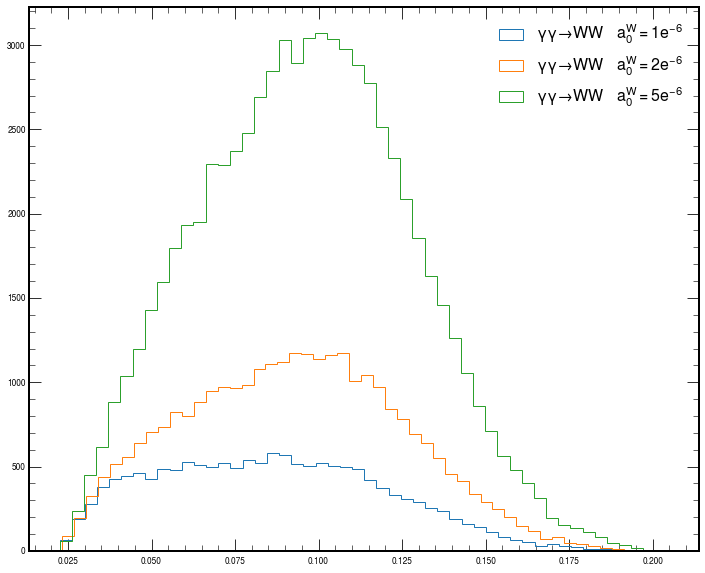

In [6]:
labels_samples = {
    "GGToWW-AQGC-A0W1e-6": r"$\gamma\gamma \to WW \quad a_0^W=1e^{-6}$",
    "GGToWW-AQGC-A0W2e-6": r"$\gamma\gamma \to WW \quad a_0^W=2e^{-6}$",
    "GGToWW-AQGC-A0W5e-6": r"$\gamma\gamma \to WW \quad a_0^W=5e^{-6}$"
}

fig = plt.figure( figsize=(12,10) )
for label_ in labels_signals: 
    plt.hist( df_signals_protons_multiRP_index[ label_ ][ 'xi' ], histtype='step', density=False, bins=50, label=labels_samples[ label_ ] )
plt.legend( loc='best', fontsize=16 )

### Ouf of acceptance protons

In [7]:
# df_signals_protons_multiRP_index_2protons = {}
# df_signals_protons_multiRP_index_1proton_Arm0 = {}
# df_signals_protons_multiRP_index_1proton_Arm1 = {}
# for label_ in labels_signals:
#     print ( label_ )
#     df_protons_multiRP_groupby_arm_ = df_signals_protons_multiRP_index[ label_ ][ [ "arm" ] ].groupby( ["run","lumiblock","event","slice"] )
#     msk_2protons_ = df_protons_multiRP_groupby_arm_[ "arm" ].transform( lambda s_: ( np.sum( s_ == 0 ) >= 1 ) & ( np.sum( s_ == 1 ) >= 1 ) )
#     msk_1proton_Arm0_ = df_protons_multiRP_groupby_arm_[ "arm" ].transform( lambda s_: ( np.sum( s_ == 0 ) >= 1 ) & ( np.sum( s_ == 1 ) == 0 ) )
#     msk_1proton_Arm1_ = df_protons_multiRP_groupby_arm_[ "arm" ].transform( lambda s_: ( np.sum( s_ == 0 ) == 0 ) & ( np.sum( s_ == 1 ) >= 1 ) )
#     print ( msk_2protons_ )
#     print ( msk_1proton_Arm0_ )
#     print ( msk_1proton_Arm1_ )
#     df_signals_protons_multiRP_index_2protons[ label_ ] = df_signals_protons_multiRP_index[ label_ ].loc[ msk_2protons_ ]
#     df_signals_protons_multiRP_index_1proton_Arm0[ label_ ] = df_signals_protons_multiRP_index[ label_ ].loc[ msk_1proton_Arm0_ ]
#     df_signals_protons_multiRP_index_1proton_Arm1[ label_ ] = df_signals_protons_multiRP_index[ label_ ].loc[ msk_1proton_Arm1_ ]

In [8]:
# label_ = "GGToWW-AQGC-A0W1e-6"
# df_signals_protons_multiRP_index_2protons[ label_ ]

In [9]:
# df_signals_protons_multiRP_index_1proton_Arm0[ label_ ]

In [10]:
# df_signals_protons_multiRP_index_1proton_Arm1[ label_ ]

In [11]:
# df_signals_protons_multiRP_index_ = df_signals_protons_multiRP_index_2protons
# # df_signals_protons_multiRP_index_ = df_signals_protons_multiRP_index_1proton_Arm0
# # df_signals_protons_multiRP_index_ = df_signals_protons_multiRP_index_1proton_Arm1
# fig = plt.figure( figsize=(12,10) )
# for label_ in labels_signals: 
#     plt.hist( df_signals_protons_multiRP_index_[ label_ ][ 'xi' ], histtype='step', density=False, bins=50, label=labels_samples[ label_ ] )
# plt.legend( loc='best', fontsize=16 )

### Signal with mixed protons

In [12]:
# run_tables = True

labels_signals_mix_protons = [ "GGToWW-AQGC-mix_protons-A0W1e-6", "GGToWW-AQGC-mix_protons-A0W2e-6", "GGToWW-AQGC-mix_protons-A0W5e-6" ]

fileNames_signals = {
    "GGToWW-AQGC-mix_protons-A0W1e-6": [ "output-GGToWW-AQGC-mix_protons-A0W1e-6.h5" ],
    "GGToWW-AQGC-mix_protons-A0W2e-6": [ "output-GGToWW-AQGC-mix_protons-A0W2e-6.h5" ],
    "GGToWW-AQGC-mix_protons-A0W5e-6": [ "output-GGToWW-AQGC-mix_protons-A0W5e-6.h5" ]
    }

df_counts_signals_mix_protons = {}
df_signals_protons_multiRP_mix_protons_index = {}
df_signals_protons_multiRP_mix_protons_events = {}

for label_ in labels_signals_mix_protons:
    import time
    print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
    time_s_ = time.time()

    #df_counts_signal, df_protons_multiRP_signal, df_protons_singleRP_signal, df_ppstracks_signal = 4 * [None]
    #df_protons_multiRP_signal_index, df_protons_multiRP_signal_events, df_ppstracks_signal_index = 3 * [None]

    if run_tables:
        with pd.HDFStore( "reduced-data-store-{}.h5".format( label_ ), complevel=5 ) as store_:

            df_counts_signal_, df_protons_multiRP_signal_, df_protons_singleRP_signal_, df_ppstracks_signal_ = get_data( fileNames_signals[ label_ ] )
            df_protons_multiRP_signal_index_, df_protons_multiRP_signal_events_, df_ppstracks_signal_index_ = process_data_protons_multiRP( df_protons_multiRP_signal_, df_ppstracks_signal_, apply_fiducial=True, within_aperture=True, mix_protons=True, select_2protons=False, runOnMC=True )

            store_[ "counts" ] = df_counts_signal_
            store_[ "protons_multiRP"] = df_protons_multiRP_signal_index_
            store_[ "events_multiRP" ] = df_protons_multiRP_signal_events_
    
    with pd.HDFStore( "reduced-data-store-{}.h5".format( label_ ), 'r' ) as store_:
        df_counts_signals_mix_protons[ label_ ] = store_[ "counts" ]
        df_signals_protons_multiRP_mix_protons_index[ label_ ] = store_[ "protons_multiRP" ]
        df_signals_protons_multiRP_mix_protons_events[ label_ ] = store_[ "events_multiRP" ]

    time_e_ = time.time()
    print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2021/05/07 16:36:15
Total time elapsed: 0
2021/05/07 16:36:15
Total time elapsed: 0
2021/05/07 16:36:15
Total time elapsed: 0


In [13]:
label_signal_to_mix_protons = {
     "GGToWW-AQGC-A0W1e-6" : "GGToWW-AQGC-mix_protons-A0W1e-6",
     "GGToWW-AQGC-A0W2e-6" : "GGToWW-AQGC-mix_protons-A0W2e-6",
     "GGToWW-AQGC-A0W5e-6" : "GGToWW-AQGC-mix_protons-A0W5e-6"
}

In [14]:
label_ = "GGToWW-AQGC-A0W1e-6"
df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ]

crossingAngle        xi           thx  \
run lumiblock event  slice                                          
1   2281      228042 0              130.0  0.040710 -1.339373e-05   
                     0              130.0  0.111005 -5.641787e-05   
    2344      234363 0              130.0  0.079774  5.526187e-05   
    4028      402796 0              120.0  0.055434  2.889099e-05   
    4033      403213 0              130.0  0.078802  1.036883e-04   
                     0              130.0  0.105974  5.218447e-05   
    4054      405396 0              150.0  0.077543  6.661195e-05   
    3867      386602 0              140.0  0.076253  8.043599e-05   
    3869      386835 0              140.0  0.110243  5.802389e-06   
    9617      461657 0              150.0  0.058753 -6.249669e-05   
    9624      462379 0              150.0  0.102959 -6.224281e-05   
                     0              150.0  0.090283 -6.088307e-05   
    245       24452  0              150.0  0.060379 -1.941511e-05   
    262       26119  0              150.0  0.098973 -3.174151e-05   
    266       26542  0              120.0  0.053062  9.638428e-05   
    7753      275282 0              150.0  0.095906  9.467000e-06   
    696       69578  0              140.0  0.120754 -9.438089e-05   
                     0              140.0  0.087492 -4.261828e-05   
    1389      138834 0              150.0  0.105080 -8.977557e-05   
    1409      140855 0              130.0  0.075610  9.029261e-06   
    1411      141005 0              150.0  0.054790  5.034913e-06   
    1423      142299 0              150.0  0.118777  8.795727e-05   
    1197      119682 0              140.0  0.043646 -8.447393e-05   
    1237      123633 0              140.0  0.059685  3.656131e-05   
                     0              140.0  0.071542 -1.464423e-05   
    1252      125192 0              130.0  0.063007 -1.922706e-05   
                     0              130.0  0.054396 -8.753509e-05   
    1269      126841 0              120.0  0.086898 -1.266863e-05   
    3559      355893 0              150.0  0.108162 -2.248296e-05   
                     0              150.0  0.114230  4.034511e-05   
...                                   ...       ...           ...   
    6112      111189 0              140.0  0.073071 -3.144582e-05   
    2527      252637 0              150.0  0.076149  2.273445e-04   
    8994      399346 0              130.0  0.040112 -4.912430e-05   
    9078      407790 0              130.0  0.104992  2.666693e-05   
    6192      119191 0              120.0  0.195953 -1.256231e-04   
    6196      119548 0              120.0  0.041619  2.534363e-05   
    5754      75341  0              120.0  0.121904 -2.305167e-06   
    5792      79158  0              130.0  0.068797  3.119822e-05   
    2416      241573 0              120.0  0.042415  4.396395e-05   
                     0              120.0  0.105568 -5.351061e-05   
    2420      241921 0              120.0  0.110685  1.931770e-05   
    6524      152372 0              130.0  0.091100  1.185909e-04   
    6455      145454 0              150.0  0.128582  1.120558e-04   
    2472      247120 0              140.0  0.091241 -2.579187e-05   
    2474      247304 0              150.0  0.054778 -1.668333e-05   
    2511      251017 0              130.0  0.106020  5.678445e-05   
              251046 0              130.0  0.067406 -1.873872e-08   
    2521      252099 0              150.0  0.064491  4.320837e-05   
    6511      151095 0              150.0  0.070216  4.609366e-05   
    9044      404341 0              150.0  0.077421 -2.119775e-05   
    9061      406041 0              130.0  0.078630  4.252567e-05   
    6237      123624 0              130.0  0.059935  4.666689e-05   
    6239      123873 0              150.0  0.072152  4.951709e-05   
    6246      124590 0              140.0  0.107533  4.653825e-06   
    6254      125328 0              150.0  0.107334  6.260812e-05   
    6469      146827 0    

In [15]:
# label_ = "GGToWW-AQGC-A0W1e-6"
# label_mix_protons_ = "GGToWW-AQGC-mix_protons-A0W1e-6"

# df_sig_2protons_ = df_signals_protons_multiRP_index_2protons[ label_ ]
# msk_arm_ = ( df_sig_2protons_.loc[ :, "arm" ] == 0 )
# df_sig_2protons_arm0_ = df_sig_2protons_.loc[ msk_arm_ ]
# index_2protons_arm0_ = df_sig_2protons_arm0_.index
# msk_arm_ = ( df_sig_2protons_.loc[ :, "arm" ] == 1 )
# df_sig_2protons_arm1_ = df_sig_2protons_.loc[ msk_arm_ ]
# index_2protons_arm1_ = df_sig_2protons_arm1_.index

# df_sig_1proton_Arm0_ = df_signals_protons_multiRP_index_1proton_Arm0[ label_ ]
# index_1proton_Arm0_ = df_sig_1proton_Arm0_.index
# df_sig_1proton_Arm1_ = df_signals_protons_multiRP_index_1proton_Arm1[ label_ ]
# index_1proton_Arm1_ = df_sig_1proton_Arm1_.index

# df_mix_ = df_signals_protons_multiRP_mix_protons_index[ label_mix_protons_ ]
# msk_arm_ = ( df_mix_.loc[ :, "arm" ] == 0 )
# df_mix_arm0_ = df_mix_.loc[ msk_arm_ ]
# index_mix_arm0_ = df_mix_arm0_.index
# msk_arm_ = ( df_mix_.loc[ :, "arm" ] == 1 )
# df_mix_arm1_ = df_mix_.loc[ msk_arm_ ]
# index_mix_arm1_ = df_mix_arm1_.index

In [16]:
# msk_sig_1proton_Arm0_mix_arm1_ = index_1proton_Arm0_.isin( index_mix_arm1_ )
# msk_mix_arm1_sig_1proton_Arm0_ = index_mix_arm1_.isin( index_1proton_Arm0_ )
# print ( np.sum( msk_sig_1proton_Arm0_mix_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_)  )
# df_sig_1proton_Arm0_mix_arm1_ = df_sig_1proton_Arm0_.loc[ msk_sig_1proton_Arm0_mix_arm1_ ]
# df_mix_arm1_sig_1proton_Arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm0_ ]
# df_1proton_Arm0_mix_Arm1_ = pd.concat( [ df_sig_1proton_Arm0_mix_arm1_, df_mix_arm1_sig_1proton_Arm0_ ] ).sort_index()

# msk_sig_1proton_Arm1_mix_arm0_ = index_1proton_Arm1_.isin( index_mix_arm0_ )
# msk_mix_arm0_sig_1proton_Arm1_ = index_mix_arm0_.isin( index_1proton_Arm1_ )
# print ( np.sum( msk_sig_1proton_Arm1_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_)  )
# df_sig_1proton_Arm1_mix_arm0_ = df_sig_1proton_Arm1_.loc[ msk_sig_1proton_Arm1_mix_arm0_ ]
# df_mix_arm0_sig_1proton_Arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm1_ ]
# df_1proton_Arm1_mix_Arm0_ = pd.concat( [ df_sig_1proton_Arm1_mix_arm0_, df_mix_arm0_sig_1proton_Arm1_ ] ).sort_index()

In [17]:
# msk_mix_arm0_sig_2protons_arm0_ = index_mix_arm0_.isin( index_2protons_arm0_ )
# msk_mix_arm0_sig_2protons_arm1_ = index_mix_arm0_.isin( index_2protons_arm1_ )
# msk_mix_arm1_sig_2protons_arm0_ = index_mix_arm1_.isin( index_2protons_arm0_ )
# msk_mix_arm1_sig_2protons_arm1_ = index_mix_arm1_.isin( index_2protons_arm1_ )
# print ( np.sum( msk_mix_arm0_sig_2protons_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_2protons_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_arm0_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_arm1_ ) )
# msk_mix_arm0_sig_1proton_Arm0_ = index_mix_arm0_.isin( index_1proton_Arm0_ )
# msk_mix_arm1_sig_1proton_Arm1_ = index_mix_arm1_.isin( index_1proton_Arm1_ )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_)  )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_)  )
# msk_mix_arm0_sig_2protons_ = ( msk_mix_arm0_sig_2protons_arm0_ | msk_mix_arm0_sig_2protons_arm1_ )
# msk_mix_arm1_sig_2protons_ = ( msk_mix_arm1_sig_2protons_arm0_ | msk_mix_arm1_sig_2protons_arm1_)
# msk_mix_arm0_ = ( msk_mix_arm0_sig_2protons_ | msk_mix_arm0_sig_1proton_Arm0_ | msk_mix_arm0_sig_1proton_Arm1_ )
# msk_mix_arm1_ = ( msk_mix_arm1_sig_2protons_ | msk_mix_arm1_sig_1proton_Arm0_ | msk_mix_arm1_sig_1proton_Arm1_ )
# print ( np.sum( msk_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm1_ ) )
# print ( np.sum( ~msk_mix_arm0_ ) )
# print ( np.sum( ~msk_mix_arm1_ ) )
# # df_mix_arm0_sig_0protons_ = df_mix_arm0_.loc[ ~msk_mix_arm0_ ]
# # df_mix_arm1_sig_0protons_ = df_mix_arm1_.loc[ ~msk_mix_arm1_ ]

In [18]:
# msk_sig_2protons_arm0_mix_arm1_ = index_2protons_arm0_.isin( index_mix_arm1_ )
# msk_sig_2protons_arm1_mix_arm1_ = index_2protons_arm1_.isin( index_mix_arm1_ )
# print ( np.sum( msk_sig_2protons_arm0_mix_arm1_ ) )
# print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_arm0_ ) )
# msk_sig_2protons_arm1_mix_arm0_ = index_2protons_arm1_.isin( index_mix_arm0_ )
# msk_sig_2protons_arm0_mix_arm0_ = index_2protons_arm0_.isin( index_mix_arm0_ )
# print ( np.sum( msk_sig_2protons_arm1_mix_arm0_ ) )
# print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_2protons_arm1_ ) )
# df_sig_2protons_arm0_mix_arm1_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm1_ ]
# df_sig_2protons_arm1_mix_arm1_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm1_ ]
# df_mix_arm1_sig_2protons_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_2protons_ ]
# # df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_.loc[ df_sig_2protons_arm0_mix_arm1_.index ].loc[ :, "eff_proton_all_weighted" ] )
# # df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ]
# df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ]
# df_2protons_Arm0_mix_Arm1_ = pd.concat( [ df_sig_2protons_arm0_mix_arm1_, df_mix_arm1_sig_2protons_arm0_ ] ).sort_index()
# df_sig_2protons_arm1_mix_arm0_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm0_ ]
# df_sig_2protons_arm0_mix_arm0_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm0_ ]
# df_mix_arm0_sig_2protons_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_2protons_arm1_ ]
# # df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_.loc[ df_sig_2protons_arm1_mix_arm0_.index ].loc[ :, "eff_proton_all_weighted" ] )
# # df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ]
# df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ]
# df_2protons_Arm1_mix_Arm0_ = pd.concat( [ df_sig_2protons_arm1_mix_arm0_, df_mix_arm0_sig_2protons_arm1_ ] ).sort_index()

In [19]:
# msk_mix_arm0_arm1_ = index_mix_arm0_.isin( index_mix_arm1_ )
# msk_mix_arm1_arm0_ = index_mix_arm1_.isin( index_mix_arm0_ )
# msk_sig_1proton_Arm0_mix_arm0_ = index_1proton_Arm0_.isin( index_mix_arm0_ )
# print ( np.sum( msk_mix_arm0_arm1_ ) )
# print ( np.sum( msk_mix_arm1_arm0_ ) )
# print ( np.sum( msk_sig_1proton_Arm0_mix_arm0_ ) )
# print ( np.sum( msk_sig_1proton_Arm0_mix_arm0_ & msk_sig_1proton_Arm0_mix_arm1_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ & msk_mix_arm0_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ & msk_mix_arm1_arm0_ ) )
# df_sig_1proton_Arm0_mix_arm0_arm1_ = df_sig_1proton_Arm0_.loc[ msk_sig_1proton_Arm0_mix_arm0_ & msk_sig_1proton_Arm0_mix_arm1_ ]
# df_mix_arm0_sig_1proton_Arm0_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm0_ & msk_mix_arm0_arm1_ ]
# df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ]
# df_mix_arm1_sig_1proton_Arm0_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm0_ & msk_mix_arm1_arm0_ ]
# df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = 1.0
# df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_all_weighted" ] = 1.0
# df_1proton_Arm0_mix_Arm0_Arm1_ = pd.concat( [ df_mix_arm0_sig_1proton_Arm0_mix_arm1_, df_mix_arm1_sig_1proton_Arm0_mix_arm0_ ] ).sort_index()

In [20]:
# msk_sig_1proton_Arm1_mix_arm1_ = index_1proton_Arm1_.isin( index_mix_arm1_ )
# print ( np.sum( msk_sig_1proton_Arm1_mix_arm1_ ) )
# print ( np.sum( msk_sig_1proton_Arm1_mix_arm1_ & msk_sig_1proton_Arm1_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_ & msk_mix_arm0_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_ & msk_mix_arm1_arm0_ ) )
# df_sig_1proton_Arm1_mix_arm1_arm0_ = df_sig_1proton_Arm1_.loc[ msk_sig_1proton_Arm1_mix_arm1_ & msk_sig_1proton_Arm1_mix_arm0_ ]
# df_mix_arm0_sig_1proton_Arm1_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm1_ & msk_mix_arm0_arm1_ ]
# df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
# df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_all_weighted" ] = 1.0
# df_mix_arm1_sig_1proton_Arm1_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm1_ & msk_mix_arm1_arm0_ ]
# df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ]
# df_1proton_Arm1_mix_Arm1_Arm0_ = pd.concat( [ df_mix_arm0_sig_1proton_Arm1_mix_arm1_, df_mix_arm1_sig_1proton_Arm1_mix_arm0_ ] ).sort_index()

In [21]:
# print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ ) )
# print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ & msk_sig_2protons_arm0_mix_arm1_ ) )
# print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ ) )
# print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ & msk_sig_2protons_arm1_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_2protons_ ) )
# print ( np.sum( msk_mix_arm0_sig_2protons_ & msk_mix_arm0_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_ & msk_mix_arm1_arm0_ ) )
# df_sig_2protons_arm0_mix_arm0_arm1_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm0_ & msk_sig_2protons_arm0_mix_arm1_ ]
# df_sig_2protons_arm1_mix_arm1_arm0_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm1_ & msk_sig_2protons_arm1_mix_arm0_ ]
# df_mix_arm0_sig_2protons_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_2protons_ & msk_mix_arm0_arm1_ ]
# df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ]
# df_mix_arm1_sig_2protons_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_2protons_ & msk_mix_arm1_arm0_ ]
# df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ]
# df_2protons_mix_Arm0_Arm1 = pd.concat( [ df_mix_arm0_sig_2protons_mix_arm1_, df_mix_arm1_sig_2protons_mix_arm0_ ] ).sort_index()

In [22]:
# def concatenate_sig_mix( label_, label_mix_protons_ ):
#     df_sig_2protons_ = df_signals_protons_multiRP_index_2protons[ label_ ]
#     msk_arm_ = ( df_sig_2protons_.loc[ :, "arm" ] == 0 )
#     df_sig_2protons_arm0_ = df_sig_2protons_.loc[ msk_arm_ ]
#     index_2protons_arm0_ = df_sig_2protons_arm0_.index
#     msk_arm_ = ( df_sig_2protons_.loc[ :, "arm" ] == 1 )
#     df_sig_2protons_arm1_ = df_sig_2protons_.loc[ msk_arm_ ]
#     index_2protons_arm1_ = df_sig_2protons_arm1_.index

#     df_sig_1proton_Arm0_ = df_signals_protons_multiRP_index_1proton_Arm0[ label_ ]
#     index_1proton_Arm0_ = df_sig_1proton_Arm0_.index
#     df_sig_1proton_Arm1_ = df_signals_protons_multiRP_index_1proton_Arm1[ label_ ]
#     index_1proton_Arm1_ = df_sig_1proton_Arm1_.index

#     df_mix_ = df_signals_protons_multiRP_mix_protons_index[ label_mix_protons_ ]
#     msk_arm_ = ( df_mix_.loc[ :, "arm" ] == 0 )
#     df_mix_arm0_ = df_mix_.loc[ msk_arm_ ]
#     index_mix_arm0_ = df_mix_arm0_.index
#     msk_arm_ = ( df_mix_.loc[ :, "arm" ] == 1 )
#     df_mix_arm1_ = df_mix_.loc[ msk_arm_ ]
#     index_mix_arm1_ = df_mix_arm1_.index
    
#     # 1 proton in Arm 0, mix in Arm 1
#     msk_sig_1proton_Arm0_mix_arm1_ = index_1proton_Arm0_.isin( index_mix_arm1_ )
#     msk_mix_arm1_sig_1proton_Arm0_ = index_mix_arm1_.isin( index_1proton_Arm0_ )
#     print ( np.sum( msk_sig_1proton_Arm0_mix_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_)  )
#     df_sig_1proton_Arm0_mix_arm1_ = df_sig_1proton_Arm0_.loc[ msk_sig_1proton_Arm0_mix_arm1_ ]
#     df_mix_arm1_sig_1proton_Arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm0_ ]
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_proton_all" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_proton_all_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_1proton_Arm0_mix_Arm1_ = pd.concat( [ df_sig_1proton_Arm0_mix_arm1_, df_mix_arm1_sig_1proton_Arm0_ ] ).sort_index()
    
#     # 1 proton in Arm 1, mix in Arm 0
#     msk_sig_1proton_Arm1_mix_arm0_ = index_1proton_Arm1_.isin( index_mix_arm0_ )
#     msk_mix_arm0_sig_1proton_Arm1_ = index_mix_arm0_.isin( index_1proton_Arm1_ )
#     print ( np.sum( msk_sig_1proton_Arm1_mix_arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_)  )
#     df_sig_1proton_Arm1_mix_arm0_ = df_sig_1proton_Arm1_.loc[ msk_sig_1proton_Arm1_mix_arm0_ ]
#     df_mix_arm0_sig_1proton_Arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm1_ ]
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_proton_all" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_1proton_Arm1_mix_Arm0_ = pd.concat( [ df_sig_1proton_Arm1_mix_arm0_, df_mix_arm0_sig_1proton_Arm1_ ] ).sort_index()
    
#     # 0 protons
#     msk_mix_arm0_sig_2protons_arm0_ = index_mix_arm0_.isin( index_2protons_arm0_ )
#     msk_mix_arm0_sig_2protons_arm1_ = index_mix_arm0_.isin( index_2protons_arm1_ )
#     msk_mix_arm1_sig_2protons_arm0_ = index_mix_arm1_.isin( index_2protons_arm0_ )
#     msk_mix_arm1_sig_2protons_arm1_ = index_mix_arm1_.isin( index_2protons_arm1_ )
#     print ( np.sum( msk_mix_arm0_sig_2protons_arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_2protons_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_2protons_arm0_ ) )
#     print ( np.sum( msk_mix_arm1_sig_2protons_arm1_ ) )
#     msk_mix_arm0_sig_1proton_Arm0_ = index_mix_arm0_.isin( index_1proton_Arm0_ )
#     msk_mix_arm1_sig_1proton_Arm1_ = index_mix_arm1_.isin( index_1proton_Arm1_ )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_)  )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_)  )
#     msk_mix_arm0_sig_2protons_ = ( msk_mix_arm0_sig_2protons_arm0_ | msk_mix_arm0_sig_2protons_arm1_ )
#     msk_mix_arm1_sig_2protons_ = ( msk_mix_arm1_sig_2protons_arm0_ | msk_mix_arm1_sig_2protons_arm1_)
#     msk_mix_arm0_ = ( msk_mix_arm0_sig_2protons_ | msk_mix_arm0_sig_1proton_Arm0_ | msk_mix_arm0_sig_1proton_Arm1_ )
#     msk_mix_arm1_ = ( msk_mix_arm1_sig_2protons_ | msk_mix_arm1_sig_1proton_Arm0_ | msk_mix_arm1_sig_1proton_Arm1_ )
#     print ( np.sum( msk_mix_arm0_ ) )
#     print ( np.sum( msk_mix_arm1_ ) )
#     print ( np.sum( ~msk_mix_arm0_ ) )
#     print ( np.sum( ~msk_mix_arm1_ ) )
#     df_mix_arm0_sig_0protons_ = df_mix_arm0_.loc[ ~msk_mix_arm0_ ]
#     df_mix_arm1_sig_0protons_ = df_mix_arm1_.loc[ ~msk_mix_arm1_ ]   
#     df_0protons_mix_Arm0_Arm1_ = pd.concat( [ df_mix_arm0_sig_0protons_, df_mix_arm1_sig_0protons_ ] ).sort_index()
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_proton_all" ] = 1.0
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0

#     # 2 protons, 1 misreconstructed
#     msk_sig_2protons_arm0_mix_arm1_ = index_2protons_arm0_.isin( index_mix_arm1_ )
#     msk_sig_2protons_arm1_mix_arm1_ = index_2protons_arm1_.isin( index_mix_arm1_ )
#     print ( np.sum( msk_sig_2protons_arm0_mix_arm1_ ) )
#     print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_2protons_arm0_ ) )
#     msk_sig_2protons_arm1_mix_arm0_ = index_2protons_arm1_.isin( index_mix_arm0_ )
#     msk_sig_2protons_arm0_mix_arm0_ = index_2protons_arm0_.isin( index_mix_arm0_ )
#     print ( np.sum( msk_sig_2protons_arm1_mix_arm0_ ) )
#     print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_2protons_arm1_ ) )
#     df_sig_2protons_arm0_mix_arm1_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm1_ ]
#     df_sig_2protons_arm1_mix_arm1_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm1_ ]
#     df_mix_arm1_sig_2protons_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_2protons_ ]
# #     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_.loc[ df_sig_2protons_arm0_mix_arm1_.index ].loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ]
# #     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_2protons_Arm0_mix_Arm1_ = pd.concat( [ df_sig_2protons_arm0_mix_arm1_, df_mix_arm1_sig_2protons_arm0_ ] ).sort_index()
#     df_sig_2protons_arm1_mix_arm0_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm0_ ]
#     df_sig_2protons_arm0_mix_arm0_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm0_ ]
#     df_mix_arm0_sig_2protons_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_2protons_arm1_ ]
# #     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_.loc[ df_sig_2protons_arm1_mix_arm0_.index ].loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ]
# #     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_2protons_Arm1_mix_Arm0_ = pd.concat( [ df_sig_2protons_arm1_mix_arm0_, df_mix_arm0_sig_2protons_arm1_ ] ).sort_index()

#     # 1 proton in Arm 0 misreconstructed, mix in Arm 1
#     msk_mix_arm0_arm1_ = index_mix_arm0_.isin( index_mix_arm1_ )
#     msk_mix_arm1_arm0_ = index_mix_arm1_.isin( index_mix_arm0_ )
#     msk_sig_1proton_Arm0_mix_arm0_ = index_1proton_Arm0_.isin( index_mix_arm0_ )
#     print ( np.sum( msk_mix_arm0_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_arm0_ ) )
#     print ( np.sum( msk_sig_1proton_Arm0_mix_arm0_ ) )
#     print ( np.sum( msk_sig_1proton_Arm0_mix_arm0_ & msk_sig_1proton_Arm0_mix_arm1_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ & msk_mix_arm0_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ & msk_mix_arm1_arm0_ ) )
#     df_sig_1proton_Arm0_mix_arm0_arm1_ = df_sig_1proton_Arm0_.loc[ msk_sig_1proton_Arm0_mix_arm0_ & msk_sig_1proton_Arm0_mix_arm1_ ]
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm0_ & msk_mix_arm0_arm1_ ]
# #     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_1proton_Arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm0_ & msk_mix_arm1_arm0_ ]
# #     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = 1.0
# #     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_all_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_proton_all" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_1proton_Arm0_mix_Arm0_Arm1_ = pd.concat( [ df_mix_arm0_sig_1proton_Arm0_mix_arm1_, df_mix_arm1_sig_1proton_Arm0_mix_arm0_ ] ).sort_index()
    
#     # 1 proton in Arm 1 misreconstructed, mix in Arm 0
#     msk_sig_1proton_Arm1_mix_arm1_ = index_1proton_Arm1_.isin( index_mix_arm1_ )
#     print ( np.sum( msk_sig_1proton_Arm1_mix_arm1_ ) )
#     print ( np.sum( msk_sig_1proton_Arm1_mix_arm1_ & msk_sig_1proton_Arm1_mix_arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_ & msk_mix_arm0_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_ & msk_mix_arm1_arm0_ ) )
#     df_sig_1proton_Arm1_mix_arm1_arm0_ = df_sig_1proton_Arm1_.loc[ msk_sig_1proton_Arm1_mix_arm1_ & msk_sig_1proton_Arm1_mix_arm0_ ]
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm1_ & msk_mix_arm0_arm1_ ]
# #     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
# #     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_all_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_proton_all" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm1_ & msk_mix_arm1_arm0_ ]
# #     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_1proton_Arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_1proton_Arm1_mix_Arm1_Arm0_ = pd.concat( [ df_mix_arm0_sig_1proton_Arm1_mix_arm1_, df_mix_arm1_sig_1proton_Arm1_mix_arm0_ ] ).sort_index()    
    
#     # 2 protons, both misreconstructed
#     print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ ) )
#     print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ & msk_sig_2protons_arm0_mix_arm1_ ) )
#     print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ ) )
#     print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ & msk_sig_2protons_arm1_mix_arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_2protons_ ) )
#     print ( np.sum( msk_mix_arm0_sig_2protons_ & msk_mix_arm0_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_2protons_ ) )
#     print ( np.sum( msk_mix_arm1_sig_2protons_ & msk_mix_arm1_arm0_ ) )
#     df_sig_2protons_arm0_mix_arm0_arm1_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm0_ & msk_sig_2protons_arm0_mix_arm1_ ]
#     df_sig_2protons_arm1_mix_arm1_arm0_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm1_ & msk_sig_2protons_arm1_mix_arm0_ ]
#     df_mix_arm0_sig_2protons_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_2protons_ & msk_mix_arm0_arm1_ ]
# #     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_mix_arm1_sig_2protons_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_2protons_ & msk_mix_arm1_arm0_ ]
# #     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_2protons_mix_Arm0_Arm1_ = pd.concat( [ df_mix_arm0_sig_2protons_mix_arm1_, df_mix_arm1_sig_2protons_mix_arm0_ ] ).sort_index()
    
#     return ( df_1proton_Arm0_mix_Arm1_,
#              df_1proton_Arm1_mix_Arm0_,
#              df_0protons_mix_Arm0_Arm1_,
#              df_2protons_Arm0_mix_Arm1_,
#              df_2protons_Arm1_mix_Arm0_,
#              df_1proton_Arm0_mix_Arm0_Arm1_,
#              df_1proton_Arm1_mix_Arm1_Arm0_,
#              df_2protons_mix_Arm0_Arm1_
#            )

In [23]:
# label_ = "GGToWW-AQGC-A0W1e-6"
# label_mix_protons_ = label_signal_to_mix_protons[ label_ ]
# df_1proton_Arm0_mix_Arm1_, df_1proton_Arm1_mix_Arm0_, df_0protons_mix_Arm0_Arm1_, df_2protons_Arm0_mix_Arm1_, df_2protons_Arm1_mix_Arm0_, df_1proton_Arm0_mix_Arm0_Arm1_, df_1proton_Arm1_mix_Arm1_Arm0_, df_2protons_mix_Arm0_Arm1_ = concatenate_sig_mix( label_, label_mix_protons_ )

In [24]:
# df_1proton_Arm0_mix_Arm1_
# # df_1proton_Arm0_mix_Arm1_[ [ "eff_proton_all", "eff_multitrack" ] ]

In [25]:
# df_1proton_Arm1_mix_Arm0_
# # df_1proton_Arm1_mix_Arm0_[ [ "eff_proton_all_weighted", "eff_all_weighted" ] ]

In [26]:
# df_0protons_mix_Arm0_Arm1_
# # df_0protons_mix_Arm0_Arm1_[ [ "eff_proton_all_weighted", "eff_all_weighted" ] ]

In [27]:
# df_2protons_Arm0_mix_Arm1_
# # df_2protons_Arm0_mix_Arm1_[ [ "eff_proton_all_weighted", "eff_all_weighted" ] ]

In [28]:
# df_2protons_Arm1_mix_Arm0_
# # df_2protons_Arm1_mix_Arm0_[ [ "eff_proton_all_weighted", "eff_all_weighted" ] ]

In [29]:
# df_1proton_Arm0_mix_Arm0_Arm1_

In [30]:
# df_1proton_Arm1_mix_Arm1_Arm0_

In [31]:
# df_2protons_mix_Arm0_Arm1_[ ['crossingAngle', 'crossingAngle_rnd'] ]

In [32]:
# labels_out_acceptance_misreconstructed_ = ( "1proton_Arm0_mix_Arm1", "1proton_Arm1_mix_Arm0", "0protons_mix_Arm0_Arm1",
#                                             "2protons_Arm0_mix_Arm1", "2protons_Arm1_mix_Arm0",
#                                             "1proton_Arm0_mix_Arm0_Arm1", "1proton_Arm1_mix_Arm1_Arm0", "2protons_mix_Arm0_Arm1" )

# df_signals_protons_multiRP_out_acceptance_misreconstructed = {}

# for label_ in labels_signals:
#     print ( label_ )
#     label_mix_protons_ = label_signal_to_mix_protons[ label_ ]
#     df_signals_protons_multiRP_out_acceptance_misreconstructed__ = concatenate_sig_mix( label_, label_mix_protons_ )
#     df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ] = {}
#     for idx_, df__ in enumerate( df_signals_protons_multiRP_out_acceptance_misreconstructed__ ):
#         print ( labels_out_acceptance_misreconstructed_[ idx_ ] )
#         df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ][ labels_out_acceptance_misreconstructed_[ idx_ ] ] = df__

In [33]:
# label_ = "GGToWW-AQGC-A0W1e-6"
# fig = plt.figure( figsize=(12,10) )
# for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ]:
#     print ( key_ )
#     df__ = df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ][ key_ ]
#     plt.hist( df__[ 'xi' ], histtype='step', bins=50, label=key_ )
# plt.legend( loc='best', fontsize=16 )

In [34]:
# label_ = "GGToWW-AQGC-A0W1e-6"
# columns_ = df_signals_protons_multiRP_index[ label_ ].columns
# columns_eff_ = columns_[ [ key_[ : len('eff') ] == 'eff' for key_ in columns_ ] ]

# columns_drop_ = [ "xi", "thx", "thy", "t", "ismultirp", "rpid", "arm", "random",
#                   "trackx1", "tracky1", "trackpixshift1", "rpid1",
#                   "trackx2", "tracky2", "trackpixshift2", "rpid2" ]
# columns_drop_eff_ = columns_drop_.copy()
# columns_drop_eff_.extend( columns_eff_ )

# df_signals_protons_multiRP_out_acceptance_misreconstructed_events = {}
# for label_ in labels_signals:
#     print ( label_ )
#     df_signals_protons_multiRP_out_acceptance_misreconstructed_events[ label_ ] = {}
#     for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ]: 
#         print ( key_ )
#         columns_drop__ = columns_drop_ if key_ in ( '0protons_mix_Arm0_Arm1', '1proton_Arm0_mix_Arm0_Arm1', '1proton_Arm1_mix_Arm1_Arm0', '2protons_mix_Arm0_Arm1' ) else columns_drop_eff_
#         df__ = df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ][ key_ ]
#         df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop__ )
#         df_signals_protons_multiRP_out_acceptance_misreconstructed_events[ label_ ][ key_ ] = df_protons_multiRP_events__

### Signal with event mixing

In [35]:
df_signals_protons_multiRP_eff_sel_index = {}
df_signals_protons_multiRP_sig_plus_mix_index = {}

np.random.seed( 12345 )

for label_ in labels_signals:
    print ( label_ )
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_proton_all" ] = 1.0
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_multitrack" ] = 1.0
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_strictzero" ] = 1.0
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_proton_all_weighted" ] = 1.0
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_multitrack_weighted" ] = 1.0
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_strictzero_weighted" ] = 1.0
    
    msk_eff_proton_ = np.random.rand( df_signals_protons_multiRP_index[ label_ ].shape[0] ) < df_signals_protons_multiRP_index[ label_ ].loc[ :, "eff_proton_all" ]
    print ( msk_eff_proton_ )
    df_signals_protons_multiRP_eff_sel_index[ label_ ] = df_signals_protons_multiRP_index[ label_ ].loc[ msk_eff_proton_ ]

#     df_signals_protons_multiRP_sig_plus_mix_index[ label_ ] = pd.concat(
#         [ df_signals_protons_multiRP_index[ label_ ],
#           df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ] ] ).sort_index()
    df_signals_protons_multiRP_sig_plus_mix_index[ label_ ] = pd.concat(
        [ df_signals_protons_multiRP_eff_sel_index[ label_ ],
          df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ] ] ).sort_index()

GGToWW-AQGC-A0W1e-6
run  lumiblock  event   slice
1    2266       226549  0        False
                226551  0         True
                        0         True
     2267       226605  0         True
                226690  0        False
     2268       226716  0         True
                226773  0        False
     2270       226932  0        False
                        0        False
     2273       227227  0         True
                        0         True
     2274       227321  0        False
                227328  0         True
                227324  0         True
     2275       227457  0        False
                        0         True
     2276       227546  0        False
                        0        False
                227579  0        False
                        0         True
     2277       227611  0         True
                227610  0        False
                227661  0         True
     2278       227745  0        False
     2279     

<ipython-input-35-6595e51fab37>:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df_signals_protons_multiRP_sig_plus_mix_index[ label_ ] = pd.concat(


GGToWW-AQGC-A0W2e-6
run  lumiblock  event   slice
1    1729       172817  0         True
                172837  0         True
                172844  0         True
     1730       172907  0        False
                        0        False
                172923  0        False
                172921  0         True
                        0        False
                172940  0         True
                        0         True
                172948  0         True
                173000  0        False
     1731       173003  0        False
                173072  0         True
                173091  0        False
                        0         True
     1732       173113  0         True
                        0         True
                173135  0         True
                173156  0         True
                173187  0        False
                        0         True
                173198  0        False
                        0        False
     1733     

In [36]:
label_ = "GGToWW-AQGC-A0W1e-6"
df_signals_protons_multiRP_index[ label_ ]

crossingAngle        xi       thx       thy  \
run lumiblock event  slice                                                
1   2266      226549 0              120.0  0.049396  0.000070  0.000006   
              226551 0              120.0  0.047449  0.000007  0.000021   
                     0              120.0  0.051457  0.000022  0.000089   
    2267      226605 0              120.0  0.129090  0.000042 -0.000010   
              226690 0              120.0  0.028568  0.000061 -0.000014   
    2268      226716 0              150.0  0.164051 -0.000072 -0.000019   
              226773 0              150.0  0.044415 -0.000016  0.000041   
    2270      226932 0              130.0  0.032306  0.000006 -0.000075   
                     0              130.0  0.119526 -0.000012  0.000005   
    2273      227227 0              130.0  0.056667 -0.000025 -0.000072   
                     0              130.0  0.053138 -0.000011 -0.000024   
    2274      227321 0              150.0  0.082597  0.000042 -0.000018   
              227328 0              150.0  0.141799 -0.000062  0.000005   
              227324 0              150.0  0.057238 -0.000019  0.000045   
    2275      227457 0              150.0  0.068920 -0.000051  0.000024   
                     0              150.0  0.115064  0.000022  0.000018   
    2276      227546 0              140.0  0.090561 -0.000041  0.000076   
                     0              140.0  0.125299 -0.000021  0.000054   
              227579 0              140.0  0.118551 -0.000022 -0.000012   
                     0              140.0  0.169634 -0.000121 -0.000032   
    2277      227611 0              130.0  0.037509  0.000041  0.000004   
              227610 0              130.0  0.088627 -0.000125 -0.000004   
              227661 0              130.0  0.057884  0.000036  0.000051   
    2278      227745 0              150.0  0.084094 -0.000080 -0.000087   
    2279      227825 0              130.0  0.067304 -0.000003  0.000013   
              227868 0              130.0  0.062334  0.000017  0.000011   
    2280      227969 0              120.0  0.085506  0.000025  0.000011   
    2282      228117 0              130.0  0.037401  0.000059  0.000036   
                     0              130.0  0.058293  0.000015  0.000080   
              228121 0              130.0  0.100883 -0.000009 -0.000044   
...                                   ...       ...       ...       ...   
    9019      401833 0              130.0  0.128527 -0.000033 -0.000013   
              401874 0              130.0  0.033579 -0.000103 -0.000091   
                     0              130.0  0.084197  0.000007  0.000073   
    9021      402066 0              119.0  0.036611  0.000072  0.000042   
                     0              119.0  0.046874  0.000018  0.000021   
              402070 0              119.0  0.042629  0.000002  0.000039   
              402092 0              119.0  0.102647 -0.000046  0.000074   
    9024      402306 0              150.0  0.101640  0.000058  0.000090   
              402311 0              150.0  0.108578 -0.000074  0.000040   
              402331 0              150.0  0.107441  0.000044  0.000004   
              402381 0              150.0  0.100368 -0.000052 -0.000037   
    9026      402504 0              150.0  0.041278  0.000096 -0.000116   
    9039      403821 0              130.0  0.102213  0.000027  0.000032   
    9041      404017 0              130.0  0.057910 -0.000056 -0.000008   
              404092 0              130.0  0.075079  0.000072 -0.000071   
              404091 0              130.0  0.132769 -0.000061  0.000051   
    9042      404200 0              140.0  0.089057  0.000003  0.000123   
    9043      404249 0              140.0  0.099805  0.000084  0.000034   
    9049      404804 0              120.0  0.086237  0.000060  0.000043   
              404867 0              120.0  0.117212 -0.000054  0.000115   
              404859 0              120.0  0.069489 -

In [37]:
df_signals_protons_multiRP_eff_sel_index[ label_ ]

crossingAngle        xi       thx       thy  \
run lumiblock event  slice                                                
1   2266      226551 0              120.0  0.047449  0.000007  0.000021   
                     0              120.0  0.051457  0.000022  0.000089   
    2267      226605 0              120.0  0.129090  0.000042 -0.000010   
    2268      226716 0              150.0  0.164051 -0.000072 -0.000019   
    2273      227227 0              130.0  0.056667 -0.000025 -0.000072   
                     0              130.0  0.053138 -0.000011 -0.000024   
    2274      227328 0              150.0  0.141799 -0.000062  0.000005   
              227324 0              150.0  0.057238 -0.000019  0.000045   
    2275      227457 0              150.0  0.115064  0.000022  0.000018   
    2276      227579 0              140.0  0.169634 -0.000121 -0.000032   
    2277      227611 0              130.0  0.037509  0.000041  0.000004   
              227661 0              130.0  0.057884  0.000036  0.000051   
    2279      227825 0              130.0  0.067304 -0.000003  0.000013   
              227868 0              130.0  0.062334  0.000017  0.000011   
    2282      228117 0              130.0  0.037401  0.000059  0.000036   
                     0              130.0  0.058293  0.000015  0.000080   
              228121 0              130.0  0.100883 -0.000009 -0.000044   
              228194 0              130.0  0.075288  0.000121  0.000027   
    2284      228336 0              120.0  0.093651 -0.000024 -0.000081   
              228335 0              120.0  0.129740  0.000070  0.000082   
    2286      228503 0              130.0  0.097616 -0.000020  0.000064   
                     0              130.0  0.106465  0.000008  0.000020   
              228565 0              130.0  0.088063 -0.000030  0.000009   
    2291      229042 0              140.0  0.030846 -0.000036 -0.000067   
                     0              140.0  0.079514 -0.000010  0.000093   
    2292      229140 0              130.0  0.100346  0.000049 -0.000080   
              229152 0              130.0  0.051193 -0.000037  0.000006   
    2294      229378 0              120.0  0.108844  0.000036  0.000069   
    2296      229519 0              120.0  0.088692 -0.000066 -0.000067   
              229520 0              120.0  0.076609 -0.000050  0.000007   
...                                   ...       ...       ...       ...   
    6553      155203 0              130.0  0.101202 -0.000006  0.000054   
    6554      155360 0              120.0  0.105238  0.000041  0.000070   
    6556      155581 0              150.0  0.095447 -0.000004 -0.000073   
    9088      408769 0              120.0  0.106919  0.000033  0.000007   
    9014      401359 0              120.0  0.085208  0.000047  0.000016   
    9015      401489 0              120.0  0.139251  0.000014  0.000003   
              401494 0              120.0  0.066395 -0.000090 -0.000097   
    9016      401522 0              150.0  0.154806 -0.000110 -0.000005   
              401525 0              150.0  0.061208  0.000031  0.000032   
    9017      401681 0              120.0  0.075163  0.000018  0.000003   
    9018      401784 0              130.0  0.117140  0.000047  0.000065   
    9019      401874 0              130.0  0.033579 -0.000103 -0.000091   
                     0              130.0  0.084197  0.000007  0.000073   
    9021      402066 0              119.0  0.046874  0.000018  0.000021   
    9024      402306 0              150.0  0.101640  0.000058  0.000090   
              402331 0              150.0  0.107441  0.000044  0.000004   
              402381 0              150.0  0.100368 -0.000052 -0.000037   
    9039      403821 0              130.0  0.102213  0.000027  0.000032   
    9041      404017 0              130.0  0.057910 -0.000056 -0.000008   
              404091 0              130.0  0.132769 -0.000061  0.000051   
    9043      404249 0              140.0  0.099805  

In [38]:
df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ]

crossingAngle        xi           thx  \
run lumiblock event  slice                                          
1   2281      228042 0              130.0  0.040710 -1.339373e-05   
                     0              130.0  0.111005 -5.641787e-05   
    2344      234363 0              130.0  0.079774  5.526187e-05   
    4028      402796 0              120.0  0.055434  2.889099e-05   
    4033      403213 0              130.0  0.078802  1.036883e-04   
                     0              130.0  0.105974  5.218447e-05   
    4054      405396 0              150.0  0.077543  6.661195e-05   
    3867      386602 0              140.0  0.076253  8.043599e-05   
    3869      386835 0              140.0  0.110243  5.802389e-06   
    9617      461657 0              150.0  0.058753 -6.249669e-05   
    9624      462379 0              150.0  0.102959 -6.224281e-05   
                     0              150.0  0.090283 -6.088307e-05   
    245       24452  0              150.0  0.060379 -1.941511e-05   
    262       26119  0              150.0  0.098973 -3.174151e-05   
    266       26542  0              120.0  0.053062  9.638428e-05   
    7753      275282 0              150.0  0.095906  9.467000e-06   
    696       69578  0              140.0  0.120754 -9.438089e-05   
                     0              140.0  0.087492 -4.261828e-05   
    1389      138834 0              150.0  0.105080 -8.977557e-05   
    1409      140855 0              130.0  0.075610  9.029261e-06   
    1411      141005 0              150.0  0.054790  5.034913e-06   
    1423      142299 0              150.0  0.118777  8.795727e-05   
    1197      119682 0              140.0  0.043646 -8.447393e-05   
    1237      123633 0              140.0  0.059685  3.656131e-05   
                     0              140.0  0.071542 -1.464423e-05   
    1252      125192 0              130.0  0.063007 -1.922706e-05   
                     0              130.0  0.054396 -8.753509e-05   
    1269      126841 0              120.0  0.086898 -1.266863e-05   
    3559      355893 0              150.0  0.108162 -2.248296e-05   
                     0              150.0  0.114230  4.034511e-05   
...                                   ...       ...           ...   
    6112      111189 0              140.0  0.073071 -3.144582e-05   
    2527      252637 0              150.0  0.076149  2.273445e-04   
    8994      399346 0              130.0  0.040112 -4.912430e-05   
    9078      407790 0              130.0  0.104992  2.666693e-05   
    6192      119191 0              120.0  0.195953 -1.256231e-04   
    6196      119548 0              120.0  0.041619  2.534363e-05   
    5754      75341  0              120.0  0.121904 -2.305167e-06   
    5792      79158  0              130.0  0.068797  3.119822e-05   
    2416      241573 0              120.0  0.042415  4.396395e-05   
                     0              120.0  0.105568 -5.351061e-05   
    2420      241921 0              120.0  0.110685  1.931770e-05   
    6524      152372 0              130.0  0.091100  1.185909e-04   
    6455      145454 0              150.0  0.128582  1.120558e-04   
    2472      247120 0              140.0  0.091241 -2.579187e-05   
    2474      247304 0              150.0  0.054778 -1.668333e-05   
    2511      251017 0              130.0  0.106020  5.678445e-05   
              251046 0              130.0  0.067406 -1.873872e-08   
    2521      252099 0              150.0  0.064491  4.320837e-05   
    6511      151095 0              150.0  0.070216  4.609366e-05   
    9044      404341 0              150.0  0.077421 -2.119775e-05   
    9061      406041 0              130.0  0.078630  4.252567e-05   
    6237      123624 0              130.0  0.059935  4.666689e-05   
    6239      123873 0              150.0  0.072152  4.951709e-05   
    6246      124590 0              140.0  0.107533  4.653825e-06   
    6254      125328 0              150.0  0.107334  6.260812e-05   
    6469      146827 0    

In [39]:
# df_signals_protons_multiRP_sig_plus_mix_index[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_index[ label_ ][ [ 'run_mc', 'run_rnd', 'period', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

run_mc   run_rnd  period  crossingAngle  \
run lumiblock event  slice                                            
1   2         190    0      305965       NaN  2017F3          130.0   
    3         256    0      305965       NaN  2017F3          130.0   
              292    0      305178       NaN  2017F2          130.0   
                     0      305178  305313.0  2017F2          130.0   
    4         330    0      302030       NaN   2017D          130.0   
    5         475    0      299337       NaN  2017C1          150.0   
                     0      299337  300515.0  2017C1          150.0   
    6         548    0      303435  304292.0   2017E          130.0   
              555    0      303435  304333.0   2017E          130.0   
              576    0      305178       NaN  2017F2          130.0   
    7         661    0      302030       NaN   2017D          130.0   
                     0      302030       NaN   2017D          130.0   
              700    0      299337       NaN  2017C1          130.0   
                     0      299337  300157.0  2017C1          130.0   
    8         719    0      297020       NaN   2017B          130.0   
    10        909    0      303435  304170.0   2017E          150.0   
              973    0      305965       NaN  2017F3          150.0   
    12        1121   0      305178       NaN  2017F2          130.0   
              1141   0      299337  300560.0  2017C1          130.0   
    13        1220   0      305178       NaN  2017F2          150.0   
                     0      305178  305204.0  2017F2          150.0   
    15        1413   0      299337       NaN  2017C1          150.0   
                     0      299337       NaN  2017C1          150.0   
              1467   0      305965       NaN  2017F3          150.0   
    16        1519   0      297020       NaN   2017B          120.0   
    17        1636   0      303435       NaN   2017E          140.0   
                     0      303435  304663.0   2017E          140.0   
              1668   0      304911       NaN  2017F1          140.0   
    19        1810   0      302030       NaN   2017D          120.0   
    20        1948   0      305965       NaN  2017F3          150.0   
...                            ...       ...     ...            ...   
    9977      497640 0      305965       NaN  2017F3          140.0   
                     0      305965  306125.0  2017F3          140.0   
    9979      497802 0      300806       NaN  2017C2          130.0   
                     0      300806  301330.0  2017C2          130.0   
              497875 0      303435  303832.0   2017E          130.0   
    9981      498038 0      305178       NaN  2017F2          120.0   
                     0      305178  305862.0  2017F2          120.0   
    9982      498159 0      299337       NaN  2017C1          150.0   
                     0      299337       NaN  2017C1          150.0   
    9983      498202 0      305178       NaN  2017F2          120.0   
                     0      305178  305365.0  2017F2          120.0   
              498238 0      303435       NaN   2017E          120.0   
    9984      498309 0      303435       NaN   2017E          130.0   
              498324 0      300806       NaN  2017C2          130.0   
    9985      498456 0      302030       NaN   2017D          120.0   
              498476 0      297020       NaN   2017B          120.0   
                     0      297020  297114.0   2017B          120.0   
    9986      498533 0      304911  305081.0  2017F1          150.0   
    9987      498657 0      303435       NaN   2017E          130.0   
    9991      499041 0      300806       NaN  2017C2          130.0   
              499091 0      303435       NaN   2017E          130.0   
    9993      499237 0      305178  305405.0  2017F2          150.0   
    9994      499358 0      305965  306092.0  2017F3          150.0   
    9995      499414 0      302030       NaN   2017D

In [40]:
df_signals_protons_multiRP_sig_plus_mix_2protons = {}
for label_ in labels_signals:
    print ( label_ )
    df_protons_multiRP_groupby_arm_ = df_signals_protons_multiRP_sig_plus_mix_index[ label_ ][ [ "arm" ] ].groupby( ["run","lumiblock","event","slice"] )
    msk_2protons_single_proton_ = df_protons_multiRP_groupby_arm_[ "arm" ].transform( lambda s_: ( np.sum( s_ == 0 ) == 1 ) & ( np.sum( s_ == 1 ) == 1 ) )
    print ( msk_2protons_single_proton_, np.sum( msk_2protons_single_proton_ ) )
    df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ] = df_signals_protons_multiRP_sig_plus_mix_index[ label_ ].loc[ msk_2protons_single_proton_ ]

GGToWW-AQGC-A0W1e-6
run  lumiblock  event   slice
1    2          190     0        False
     3          256     0        False
                292     0        False
                        0        False
     4          330     0        False
     5          475     0        False
                        0        False
     6          548     0        False
                555     0        False
                576     0        False
     7          661     0         True
                        0         True
                700     0        False
                        0        False
     8          719     0        False
     10         909     0        False
                973     0        False
     12         1121    0        False
                1141    0        False
     13         1220    0         True
                        0         True
     15         1413    0         True
                        0         True
                1467    0        False
     16       

In [41]:
label_ = "GGToWW-AQGC-A0W1e-6"
# df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ][ [ 'run_mc', 'run_rnd', 'period', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

run_mc   run_rnd  period  crossingAngle  \
run lumiblock event  slice                                            
1   7         661    0      302030       NaN   2017D          130.0   
                     0      302030       NaN   2017D          130.0   
    13        1220   0      305178       NaN  2017F2          150.0   
                     0      305178  305204.0  2017F2          150.0   
    15        1413   0      299337       NaN  2017C1          150.0   
                     0      299337       NaN  2017C1          150.0   
    29        2846   0      305178       NaN  2017F2          150.0   
                     0      305178  305814.0  2017F2          150.0   
    34        3364   0      300806       NaN  2017C2          150.0   
                     0      300806  301997.0  2017C2          150.0   
    39        3832   0      305178       NaN  2017F2          130.0   
                     0      305178  305406.0  2017F2          130.0   
    45        4462   0      297020       NaN   2017B          150.0   
                     0      297020       NaN   2017B          150.0   
    47        4636   0      305178       NaN  2017F2          130.0   
                     0      305178  305364.0  2017F2          130.0   
    50        4970   0      303435       NaN   2017E          120.0   
                     0      303435  304738.0   2017E          120.0   
    52        5147   0      302030  302228.0   2017D          130.0   
                     0      302030  302228.0   2017D          130.0   
    54        5302   0      305178       NaN  2017F2          120.0   
                     0      305178       NaN  2017F2          120.0   
    72        7117   0      299337  299593.0  2017C1          150.0   
                     0      299337  299593.0  2017C1          150.0   
    78        7721   0      303435  304777.0   2017E          140.0   
                     0      303435  304777.0   2017E          140.0   
    81        8018   0      299337       NaN  2017C1          150.0   
                     0      299337       NaN  2017C1          150.0   
    93        9298   0      302030       NaN   2017D          120.0   
                     0      302030  302573.0   2017D          120.0   
...                            ...       ...     ...            ...   
    9922      492154 0      300806       NaN  2017C2          120.0   
                     0      300806       NaN  2017C2          120.0   
    9928      492715 0      305178       NaN  2017F2          140.0   
                     0      305178       NaN  2017F2          140.0   
    9937      493601 0      302030       NaN   2017D          120.0   
                     0      302030  302572.0   2017D          120.0   
    9942      494129 0      297020       NaN   2017B          150.0   
                     0      297020       NaN   2017B          150.0   
    9950      494979 0      305965       NaN  2017F3          150.0   
                     0      305965  306459.0  2017F3          150.0   
    9956      495568 0      300806       NaN  2017C2          120.0   
                     0      300806  301665.0  2017C2          120.0   
    9965      496415 0      304911       NaN  2017F1          120.0   
                     0      304911  305045.0  2017F1          120.0   
    9966      496511 0      304911       NaN  2017F1          140.0   
                     0      304911  305112.0  2017F1          140.0   
    9968      496707 0      305178  305252.0  2017F2          150.0   
                     0      305178  305252.0  2017F2          150.0   
    9970      496950 0      300806       NaN  2017C2          150.0   
                     0      300806       NaN  2017C2          150.0   
    9977      497640 0      305965       NaN  2017F3          140.0   
                     0      305965  306125.0  2017F3          140.0   
    9979      497802 0      300806       NaN  2017C2          130.0   
                     0      300806  301330.0  2017C2

In [42]:
df_signals_protons_multiRP_sig_plus_mix_2protons_sig = {}
df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0 = {}
df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1 = {}
df_signals_protons_multiRP_sig_plus_mix_2protons_mix = {}
for label_ in labels_signals:
    print ( label_ )
#     df_protons_multiRP_groupby_random_ = df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ][ [ "random" ] ].groupby( ["run","lumiblock","event","slice"] )
#     msk_2protons_ = df_protons_multiRP_groupby_random_[ "random" ].transform( lambda s_: ( np.sum( s_ == 0 ) == 2 ) )
#     msk_1proton_sig_ = df_protons_multiRP_groupby_random_[ "random" ].transform( lambda s_: ( np.sum( s_ == 0 ) == 1 ) )
#     msk_2protons_mix_ = df_protons_multiRP_groupby_random_[ "random" ].transform( lambda s_: ( np.sum( s_ == 0 ) == 0 ) )
#     print ( msk_2protons_, np.sum( msk_2protons_ ) )
#     print ( msk_1proton_sig_, np.sum( msk_1proton_sig_ ) )
#     print ( msk_2protons_mix_, np.sum( msk_2protons_mix_ ) )
    
    df__ = df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ]
    df_protons_multiRP_groupby__ = df__[ [ "arm", "random" ] ].groupby( ["run","lumiblock","event","slice"] )
    msk_sig_Arm0_ = df_protons_multiRP_groupby__.apply( lambda __df: np.sum( ( __df[ 'arm' ] == 0 ) & ( __df[ 'random' ] == 0 ) ) == 1 )
    msk_sig_Arm1_ = df_protons_multiRP_groupby__.apply( lambda __df: np.sum( ( __df[ 'arm' ] == 1 ) & ( __df[ 'random' ] == 0 ) ) == 1 )
    msk_2protons_ = ( msk_sig_Arm0_ & msk_sig_Arm1_ )
    msk_1proton_sig_Arm0_ = ( msk_sig_Arm0_ & ~msk_sig_Arm1_ )
    msk_1proton_sig_Arm1_ = ( ~msk_sig_Arm0_ & msk_sig_Arm1_ )
    msk_2protons_mix_ = ( ~msk_sig_Arm0_ & ~msk_sig_Arm1_ )
    print ( msk_2protons_, np.sum( msk_2protons_ ) )
    print ( msk_1proton_sig_Arm0_, np.sum( msk_1proton_sig_Arm0_ ) )
    print ( msk_1proton_sig_Arm1_, np.sum( msk_1proton_sig_Arm1_ ) )
    print ( msk_2protons_mix_, np.sum( msk_2protons_mix_ ) )
    
    df_signals_protons_multiRP_sig_plus_mix_2protons_sig[ label_ ] = df__.loc[ msk_2protons_ ]
    df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0[ label_ ] = df__.loc[ msk_1proton_sig_Arm0_ ]
    df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1[ label_ ] = df__.loc[ msk_1proton_sig_Arm1_ ]
    df_signals_protons_multiRP_sig_plus_mix_2protons_mix[ label_ ] = df__.loc[ msk_2protons_mix_ ]

GGToWW-AQGC-A0W1e-6
run  lumiblock  event   slice
1    7          661     0         True
     13         1220    0        False
     15         1413    0         True
     29         2846    0        False
     34         3364    0        False
     39         3832    0        False
     45         4462    0         True
     47         4636    0        False
     50         4970    0        False
     52         5147    0        False
     54         5302    0         True
     72         7117    0        False
     78         7721    0        False
     81         8018    0         True
     93         9298    0        False
     98         9713    0        False
                9730    0         True
     103        10231   0        False
     105        10427   0        False
     109        10818   0         True
     113        11246   0        False
     114        11390   0        False
     118        11748   0         True
     121        12011   0         True
     129      

run  lumiblock  event   slice
1    3          204     0         True
     9          835     0        False
                862     0         True
     13         1269    0         True
     15         1470    0        False
     18         1767    0        False
                1779    0        False
     20         2000    0        False
     22         2108    0        False
     23         2259    0        False
     25         2403    0        False
                2423    0         True
     27         2643    0         True
     33         3233    0        False
                3242    0         True
     35         3425    0        False
                3492    0        False
     38         3720    0         True
     44         4363    0         True
     49         4896    0         True
     51         5047    0         True
     52         5151    0        False
     53         5300    0         True
     54         5400    0         True
     56         5587    0        F

run  lumiblock  event   slice
1    1          20      0         True
                24      0         True
     2          146     0         True
                149     0        False
     4          315     0        False
                336     0         True
     5          420     0        False
                427     0        False
     6          571     0        False
                581     0        False
                582     0        False
     7          624     0        False
                695     0        False
     9          847     0        False
     12         1109    0        False
     13         1209    0        False
                1253    0        False
     15         1413    0        False
     17         1610    0        False
     19         1823    0        False
     21         2008    0        False
                2077    0        False
     22         2161    0        False
     23         2261    0        False
     24         2346    0        F

In [43]:
label_ = "GGToWW-AQGC-A0W1e-6"
# df_signals_protons_multiRP_sig_plus_mix_2protons_sig[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_2protons_sig[ label_ ][ [ 'run_mc', 'period', 'arm', 'random', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

run_mc  period  arm  random  crossingAngle  \
run lumiblock event  slice                                               
1   7         661    0      302030   2017D    0       0          130.0   
                     0      302030   2017D    1       0          130.0   
    15        1413   0      299337  2017C1    0       0          150.0   
                     0      299337  2017C1    1       0          150.0   
    45        4462   0      297020   2017B    0       0          150.0   
                     0      297020   2017B    1       0          150.0   
    54        5302   0      305178  2017F2    0       0          120.0   
                     0      305178  2017F2    1       0          120.0   
    81        8018   0      299337  2017C1    0       0          150.0   
                     0      299337  2017C1    1       0          150.0   
    98        9730   0      305178  2017F2    0       0          140.0   
                     0      305178  2017F2    1       0          140.0   
    109       10818  0      302030   2017D    0       0          140.0   
                     0      302030   2017D    1       0          140.0   
    118       11748  0      302030   2017D    0       0          150.0   
                     0      302030   2017D    1       0          150.0   
    121       12011  0      303435   2017E    0       0          150.0   
                     0      303435   2017E    1       0          150.0   
    141       14060  0      302030   2017D    0       0          130.0   
                     0      302030   2017D    1       0          130.0   
    158       15790  0      299337  2017C1    0       0          130.0   
                     0      299337  2017C1    1       0          130.0   
    159       15886  0      305178  2017F2    0       0          130.0   
                     0      305178  2017F2    1       0          130.0   
    171       17026  0      305178  2017F2    0       0          150.0   
                     0      305178  2017F2    1       0          150.0   
    180       17927  0      299337  2017C1    0       0          140.0   
                     0      299337  2017C1    1       0          140.0   
    185       18450  0      305178  2017F2    0       0          150.0   
                     0      305178  2017F2    1       0          150.0   
...                            ...     ...  ...     ...            ...   
    9861      486093 0      305178  2017F2    0       0          130.0   
                     0      305178  2017F2    1       0          130.0   
    9862      486154 0      299337  2017C1    0       0          120.0   
                     0      299337  2017C1    1       0          120.0   
    9864      486374 0      299337  2017C1    0       0          130.0   
                     0      299337  2017C1    1       0          130.0   
    9877      487666 0      305178  2017F2    0       0          150.0   
                     0      305178  2017F2    1       0          150.0   
    9881      488006 0      305178  2017F2    0       0          140.0   
                     0      305178  2017F2    1       0          140.0   
    9887      488636 0      299337  2017C1    0       0          120.0   
                     0      299337  2017C1    1       0          120.0   
              488668 0      302030   2017D    0       0          120.0   
                     0      302030   2017D    1       0          120.0   
    9898      489788 0      305178  2017F2    0       0          140.0   
                     0      305178  2017F2    1       0          140.0   
    9907      490626 0      305178  2017F2    0       0          150.0   
                     0      305178  2017F2    1       0          150.0   
    9922      492154 0      300806  2017C2    0       0          120.0   
                     0      300806  2017C2    1       0          120.0   
    9928      492715 0      305178  2017F2    0       0          140.0   
                     0      3051

In [44]:
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0[ label_ ][ [ 'run_mc', 'period', 'arm', 'random', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

run_mc  period  arm  random  crossingAngle  \
run lumiblock event  slice                                               
1   29        2846   0      305178  2017F2    0       0          150.0   
                     0      305178  2017F2    1       1          150.0   
    34        3364   0      300806  2017C2    0       0          150.0   
                     0      300806  2017C2    1       1          150.0   
    39        3832   0      305178  2017F2    0       0          130.0   
                     0      305178  2017F2    1       1          130.0   
    47        4636   0      305178  2017F2    0       0          130.0   
                     0      305178  2017F2    1       1          130.0   
    129       12850  0      302030   2017D    0       0          130.0   
                     0      302030   2017D    1       1          130.0   
    130       12922  0      302030   2017D    0       0          130.0   
                     0      302030   2017D    1       1          130.0   
    137       13645  0      305178  2017F2    0       0          120.0   
                     0      305178  2017F2    1       1          120.0   
    145       14421  0      299337  2017C1    0       0          120.0   
                     0      299337  2017C1    1       1          120.0   
    187       18665  0      302030   2017D    0       0          140.0   
                     0      302030   2017D    1       1          140.0   
    209       20845  0      300806  2017C2    0       0          120.0   
                     0      300806  2017C2    1       1          120.0   
    248       24707  0      305965  2017F3    0       0          130.0   
                     0      305965  2017F3    1       1          130.0   
    262       26119  0      297020   2017B    0       0          150.0   
                     0      297020   2017B    1       1          150.0   
    268       26800  0      305965  2017F3    0       0          150.0   
                     0      305965  2017F3    1       1          150.0   
    269       26883  0      302030   2017D    0       0          130.0   
                     0      302030   2017D    1       1          130.0   
    309       30888  0      299337  2017C1    0       0          150.0   
                     0      299337  2017C1    1       1          150.0   
...                            ...     ...  ...     ...            ...   
    9516      451598 0      305178  2017F2    0       0          130.0   
                     0      305178  2017F2    1       1          130.0   
    9573      457297 0      302030   2017D    0       0          130.0   
                     0      302030   2017D    1       1          130.0   
    9590      458995 0      299337  2017C1    0       0          130.0   
                     0      299337  2017C1    1       1          130.0   
    9643      464294 0      305178  2017F2    0       0          140.0   
                     0      305178  2017F2    1       1          140.0   
    9656      465557 0      305965  2017F3    0       0          130.0   
                     0      305965  2017F3    1       1          130.0   
    9685      468481 0      305178  2017F2    0       0          130.0   
                     0      305178  2017F2    1       1          130.0   
    9689      468865 0      299337  2017C1    0       0          150.0   
                     0      299337  2017C1    1       1          150.0   
    9742      474128 0      302030   2017D    0       0          120.0   
                     0      302030   2017D    1       1          120.0   
    9789      478817 0      305178  2017F2    0       0          130.0   
                     0      305178  2017F2    1       1          130.0   
    9795      479435 0      299337  2017C1    0       0          150.0   
                     0      299337  2017C1    1       1          150.0   
    9849      484842 0      302030   2017D    0       0          150.0   
                     0      3020

In [45]:
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1[ label_ ][ [ 'run_mc', 'period', 'arm', 'random', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

run_mc  period  arm  random  crossingAngle  \
run lumiblock event  slice                                               
1   13        1220   0      305178  2017F2    1       0          150.0   
                     0      305178  2017F2    0       1          150.0   
    50        4970   0      303435   2017E    1       0          120.0   
                     0      303435   2017E    0       1          120.0   
    93        9298   0      302030   2017D    1       0          120.0   
                     0      302030   2017D    0       1          120.0   
    103       10231  0      302030   2017D    1       0          150.0   
                     0      302030   2017D    0       1          150.0   
    105       10427  0      302030   2017D    1       0          140.0   
                     0      302030   2017D    0       1          140.0   
    113       11246  0      302030   2017D    1       0          140.0   
                     0      302030   2017D    0       1          140.0   
    184       18330  0      305178  2017F2    1       0          140.0   
                     0      305178  2017F2    0       1          140.0   
    202       20175  0      302030   2017D    1       0          140.0   
                     0      302030   2017D    0       1          140.0   
    215       21403  0      305178  2017F2    1       0          150.0   
                     0      305178  2017F2    0       1          150.0   
    217       21614  0      300806  2017C2    1       0          130.0   
                     0      300806  2017C2    0       1          130.0   
    281       28069  0      299337  2017C1    1       0          130.0   
                     0      299337  2017C1    0       1          130.0   
    294       29320  0      299337  2017C1    1       0          150.0   
                     0      299337  2017C1    0       1          150.0   
    336       33510  0      304911  2017F1    1       0          120.0   
                     0      304911  2017F1    0       1          120.0   
    347       34627  0      305178  2017F2    1       0          120.0   
                     0      305178  2017F2    0       1          120.0   
    371       37054  0      305178  2017F2    1       0          140.0   
                     0      305178  2017F2    0       1          140.0   
...                            ...     ...  ...     ...            ...   
    9831      483027 0      300806  2017C2    1       0          150.0   
                     0      300806  2017C2    0       1          150.0   
    9843      484259 0      305178  2017F2    1       0          120.0   
                     0      305178  2017F2    0       1          120.0   
    9866      486578 0      303435   2017E    1       0          120.0   
                     0      303435   2017E    0       1          120.0   
    9868      486713 0      304911  2017F1    1       0          150.0   
                     0      304911  2017F1    0       1          150.0   
    9872      487197 0      300806  2017C2    1       0          140.0   
                     0      300806  2017C2    0       1          140.0   
    9884      488363 0      300806  2017C2    1       0          120.0   
                     0      300806  2017C2    0       1          120.0   
    9890      488945 0      305178  2017F2    1       0          130.0   
                     0      305178  2017F2    0       1          130.0   
    9896      489556 0      304911  2017F1    1       0          120.0   
                     0      304911  2017F1    0       1          120.0   
    9921      492078 0      302030   2017D    1       0          110.0   
                     0      302030   2017D    0       1          110.0   
    9937      493601 0      302030   2017D    1       0          120.0   
                     0      302030   2017D    0       1          120.0   
    9956      495568 0      300806  2017C2    1       0          120.0   
                     0      3008

In [46]:
# df_signals_protons_multiRP_sig_plus_mix_2protons_mix[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_2protons_mix[ label_ ][ [ 'run_mc', 'period', 'arm', 'random', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

run_mc  period  arm  random  crossingAngle  \
run lumiblock event  slice                                               
1   52        5147   0      302030   2017D    0       1          130.0   
                     0      302030   2017D    1       1          130.0   
    72        7117   0      299337  2017C1    0       1          150.0   
                     0      299337  2017C1    1       1          150.0   
    78        7721   0      303435   2017E    0       1          140.0   
                     0      303435   2017E    1       1          140.0   
    98        9713   0      299337  2017C1    0       1          140.0   
                     0      299337  2017C1    1       1          140.0   
    114       11390  0      305178  2017F2    0       1          140.0   
                     0      305178  2017F2    1       1          140.0   
    199       19891  0      305965  2017F3    0       1          130.0   
                     0      305965  2017F3    1       1          130.0   
    278       27780  0      299337  2017C1    0       1          130.0   
                     0      299337  2017C1    1       1          130.0   
    336       33511  0      300806  2017C2    0       1          120.0   
                     0      300806  2017C2    1       1          120.0   
    353       35209  0      297020   2017B    0       1          130.0   
                     0      297020   2017B    1       1          130.0   
    375       37430  0      303435   2017E    0       1          140.0   
                     0      303435   2017E    1       1          140.0   
    419       41862  0      299337  2017C1    0       1          140.0   
                     0      299337  2017C1    1       1          140.0   
    446       44582  0      299337  2017C1    0       1          120.0   
                     0      299337  2017C1    1       1          120.0   
    477       47623  0      304911  2017F1    0       1          130.0   
                     0      304911  2017F1    1       1          130.0   
    585       58454  0      299337  2017C1    0       1          120.0   
                     0      299337  2017C1    1       1          120.0   
    603       60281  0      299337  2017C1    0       1          140.0   
                     0      299337  2017C1    1       1          140.0   
...                            ...     ...  ...     ...            ...   
    9614      461336 0      303435   2017E    0       1          150.0   
                     0      303435   2017E    1       1          150.0   
    9636      463502 0      299337  2017C1    0       1          140.0   
                     0      299337  2017C1    1       1          140.0   
              463573 0      305178  2017F2    0       1          140.0   
                     0      305178  2017F2    1       1          140.0   
    9648      464785 0      305965  2017F3    0       1          150.0   
                     0      305965  2017F3    1       1          150.0   
    9657      465618 0      305965  2017F3    0       1          120.0   
                     0      305965  2017F3    1       1          120.0   
    9660      465903 0      305178  2017F2    0       1          130.0   
                     0      305178  2017F2    1       1          130.0   
              465920 0      302030   2017D    0       1          130.0   
                     0      302030   2017D    1       1          130.0   
    9665      466435 0      299337  2017C1    0       1          130.0   
                     0      299337  2017C1    1       1          130.0   
    9720      471972 0      297020   2017B    0       1          150.0   
                     0      297020   2017B    1       1          150.0   
    9828      482775 0      305178  2017F2    0       1          130.0   
                     0      305178  2017F2    1       1          130.0   
    9886      488565 0      297020   2017B    0       1          140.0   
                     0      2970

In [47]:
label_ = "GGToWW-AQGC-A0W1e-6"
columns_ = df_signals_protons_multiRP_sig_plus_mix_index[ label_ ].columns
columns_eff_ = columns_[ [ key_[ : len('eff') ] == 'eff' for key_ in columns_ ] ]

columns_drop_ = [ "xi", "thx", "thy", "t", "ismultirp", "rpid", "arm", "random",
                  "trackx1", "tracky1", "trackpixshift1", "rpid1",
                  "trackx2", "tracky2", "trackpixshift2", "rpid2" ]
columns_drop_eff_ = columns_drop_.copy()
columns_drop_eff_.extend( columns_eff_ )

df_signals_protons_multiRP_sig_plus_mix_2protons_events = {}
# df_signals_protons_multiRP_sig_plus_mix_2protons_sig_events = {}
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0_events = {}
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1_events = {}
# df_signals_protons_multiRP_sig_plus_mix_2protons_mix_events = {}
df_signals_protons_multiRP_sig_plus_mix_events_categories = {}

for label_ in labels_signals:
    print ( label_ )
    df__ = df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ]
    df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop_eff_ )
    df_signals_protons_multiRP_sig_plus_mix_2protons_events[ label_ ] = df_protons_multiRP_events__
    
    df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ] = {}
    df__ = df_signals_protons_multiRP_sig_plus_mix_2protons_sig[ label_ ]
    df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop_eff_ )
#     df_signals_protons_multiRP_sig_plus_mix_2protons_sig_events[ label_ ] = df_protons_multiRP_events__
    df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '2protons_sig' ] = df_protons_multiRP_events__
    df__ = df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0[ label_ ]
    df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop_eff_ )
#     df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0_events[ label_ ] = df_protons_multiRP_events__
    df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '1proton_sig_Arm0' ] = df_protons_multiRP_events__
    df__ = df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1[ label_ ]
    df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop_eff_ )
#     df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1_events[ label_ ] = df_protons_multiRP_events__
    df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '1proton_sig_Arm1' ] = df_protons_multiRP_events__
    df__ = df_signals_protons_multiRP_sig_plus_mix_2protons_mix[ label_ ]
    df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop_eff_ )
#     df_signals_protons_multiRP_sig_plus_mix_2protons_mix_events[ label_ ] = df_protons_multiRP_events__
    df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '2protons_mix' ] = df_protons_multiRP_events__

GGToWW-AQGC-A0W1e-6
run  lumiblock  event   slice
1    7          661     0        True
                        0        True
     13         1220    0        True
                        0        True
     15         1413    0        True
                        0        True
     29         2846    0        True
                        0        True
     34         3364    0        True
                        0        True
     39         3832    0        True
                        0        True
     45         4462    0        True
                        0        True
     47         4636    0        True
                        0        True
     50         4970    0        True
                        0        True
     52         5147    0        True
                        0        True
     54         5302    0        True
                        0        True
     72         7117    0        True
                        0        True
     78         7721    0        True


run  lumiblock  event   slice
1    7          661     0        0.305169
     13         1220    0        0.538512
     15         1413    0        0.305169
     29         2846    0        0.566690
     34         3364    0        0.566690
     39         3832    0        0.566690
     45         4462    0        0.305169
     47         4636    0        0.566690
     50         4970    0        0.538512
     52         5147    0        1.000000
     54         5302    0        0.305169
     72         7117    0        1.000000
     78         7721    0        1.000000
     81         8018    0        0.305169
     93         9298    0        0.538512
     98         9713    0        1.000000
                9730    0        0.305169
     103        10231   0        0.538512
     105        10427   0        0.538512
     109        10818   0        0.305169
     113        11246   0        0.538512
     114        11390   0        1.000000
     118        11748   0        0.305169
    

run  lumiblock  event   slice
1    7          661     0        0.584179
     13         1220    0        0.286200
     15         1413    0        0.383830
     29         2846    0        0.359300
     34         3364    0        0.651000
     39         3832    0        0.466700
     45         4462    0        0.378233
     47         4636    0        0.466700
     50         4970    0        0.630700
     52         5147    0        1.000000
     54         5302    0        0.411786
     72         7117    0        1.000000
     78         7721    0        1.000000
     81         8018    0        0.383830
     93         9298    0        0.827300
     98         9713    0        1.000000
                9730    0        0.120218
     103        10231   0        0.601000
     105        10427   0        0.672900
     109        10818   0        0.494783
     113        11246   0        0.672900
     114        11390   0        1.000000
     118        11748   0        0.403451
    

run  lumiblock  event   slice
1    7          661     0        0.524142
     15         1413    0        0.394788
     45         4462    0        0.466756
     54         5302    0        0.438535
     81         8018    0        0.469020
     98         9730    0        0.462810
     109        10818   0        0.485237
     118        11748   0        0.487649
     121        12011   0        0.069531
     141        14060   0        0.391360
     158        15790   0        0.528427
     159        15886   0        0.465584
     171        17026   0        0.463076
     180        17927   0        0.394394
     185        18450   0        0.521953
     200        19968   0        0.276404
     254        25349   0        0.541725
     255        25410   0        0.465847
     290        28991   0        0.460007
     296        29577   0        0.537711
     306        30593   0        0.539896
     308        30735   0        0.537859
     325        32497   0        0.473336
    

run  lumiblock  event   slice
1    7          661     0        0.584179
     15         1413    0        0.383830
     45         4462    0        0.378233
     54         5302    0        0.411786
     81         8018    0        0.383830
     98         9730    0        0.120218
     109        10818   0        0.494783
     118        11748   0        0.403451
     121        12011   0        0.101437
     141        14060   0        0.584179
     158        15790   0        0.583712
     159        15886   0        0.177953
     171        17026   0        0.102832
     180        17927   0        0.474449
     185        18450   0        0.102832
     200        19968   0        0.120218
     254        25349   0        0.411786
     255        25410   0        0.411786
     290        28991   0        0.716855
     296        29577   0        0.727102
     306        30593   0        0.583712
     308        30735   0        0.177953
     325        32497   0        0.177953
    

run  lumiblock  event   slice
1    29         2846    0        0.56669
     34         3364    0        0.56669
     39         3832    0        0.56669
     47         4636    0        0.56669
     129        12850   0        0.56669
     130        12922   0        0.56669
     137        13645   0        0.56669
     145        14421   0        0.56669
     187        18665   0        0.56669
     209        20845   0        0.56669
     248        24707   0        0.56669
     262        26119   0        0.56669
     268        26800   0        0.56669
     269        26883   0        0.56669
     309        30888   0        0.56669
     329        32851   0        0.56669
     394        39329   0        0.56669
     396        39544   0        0.56669
     398        39761   0        0.56669
     412        41169   0        0.56669
     449        44888   0        0.56669
     503        50273   0        0.56669
     507        50616   0        0.56669
     517        51651   0  

run  lumiblock  event   slice
1    13         1220    0        True
                        0        True
     50         4970    0        True
                        0        True
     93         9298    0        True
                        0        True
     103        10231   0        True
                        0        True
     105        10427   0        True
                        0        True
     113        11246   0        True
                        0        True
     184        18330   0        True
                        0        True
     202        20175   0        True
                        0        True
     215        21403   0        True
                        0        True
     217        21614   0        True
                        0        True
     281        28069   0        True
                        0        True
     294        29320   0        True
                        0        True
     336        33510   0        True
                    

run  lumiblock  event   slice
1    13         1220    0        0.411265
     50         4970    0        0.704154
     93         9298    0        0.704154
     103        10231   0        0.411265
     105        10427   0        0.450983
     113        11246   0        0.450983
     184        18330   0        0.450983
     202        20175   0        0.450983
     215        21403   0        0.411265
     217        21614   0        0.529818
     281        28069   0        0.529818
     294        29320   0        0.411265
     336        33510   0        0.704154
     347        34627   0        0.704154
     371        37054   0        0.450983
                37069   0        0.450983
     377        37602   0        0.411265
     392        39115   0        0.411265
     420        41943   0        0.411265
     434        43368   0        0.704154
     442        44146   0        0.704154
     455        45491   0        0.529818
     456        45516   0        0.411265
    

run  lumiblock  event   slice
1    52         5147    0        True
                        0        True
     72         7117    0        True
                        0        True
     78         7721    0        True
                        0        True
     98         9713    0        True
                        0        True
     114        11390   0        True
                        0        True
     199        19891   0        True
                        0        True
     278        27780   0        True
                        0        True
     336        33511   0        True
                        0        True
     353        35209   0        True
                        0        True
     375        37430   0        True
                        0        True
     419        41862   0        True
                        0        True
     446        44582   0        True
                        0        True
     477        47623   0        True
                    

run  lumiblock  event   slice
1    52         5147    0        1.0
     72         7117    0        1.0
     78         7721    0        1.0
     98         9713    0        1.0
     114        11390   0        1.0
     199        19891   0        1.0
     278        27780   0        1.0
     336        33511   0        1.0
     353        35209   0        1.0
     375        37430   0        1.0
     419        41862   0        1.0
     446        44582   0        1.0
     477        47623   0        1.0
     585        58454   0        1.0
     603        60281   0        1.0
     608        60795   0        1.0
     627        62645   0        1.0
     654        65335   0        1.0
     696        69578   0        1.0
     739        73867   0        1.0
     765        76451   0        1.0
     768        76777   0        1.0
     805        80422   0        1.0
     809        80802   0        1.0
     844        84375   0        1.0
     878        87762   0        1.0
     945

run  lumiblock  event   slice
1    3          204     0        True
                        0        True
     9          835     0        True
                        0        True
                862     0        True
                        0        True
     13         1269    0        True
                        0        True
     15         1470    0        True
                        0        True
     18         1767    0        True
                        0        True
                1779    0        True
                        0        True
     20         2000    0        True
                        0        True
     22         2108    0        True
                        0        True
     23         2259    0        True
                        0        True
     25         2403    0        True
                        0        True
                2423    0        True
                        0        True
     27         2643    0        True
                    

run  lumiblock  event   slice
1    3          204     0        0.305169
     9          835     0        1.000000
                862     0        0.305169
     13         1269    0        0.305169
     15         1470    0        0.566690
     18         1767    0        1.000000
                1779    0        0.566690
     20         2000    0        0.538512
     22         2108    0        0.566690
     23         2259    0        0.538512
     25         2403    0        0.538512
                2423    0        0.305169
     27         2643    0        0.305169
     33         3233    0        0.566690
                3242    0        0.305169
     35         3425    0        0.566690
                3492    0        0.566690
     38         3720    0        0.305169
     44         4363    0        0.305169
     49         4896    0        0.305169
     51         5047    0        0.305169
     52         5151    0        0.538512
     53         5300    0        0.305169
    

run  lumiblock  event   slice
1    3          204     0        0.120218
     9          835     0        1.000000
                862     0        0.102832
     13         1269    0        0.584179
     15         1470    0        0.868700
     18         1767    0        1.000000
                1779    0        0.671300
     20         2000    0        0.381300
     22         2108    0        0.349300
     23         2259    0        0.397600
     25         2403    0        0.605300
                2423    0        0.411786
     27         2643    0        0.102832
     33         3233    0        0.635900
                3242    0        0.383830
     35         3425    0        0.466700
                3492    0        0.466700
     38         3720    0        0.583712
     44         4363    0        0.727102
     49         4896    0        0.583712
     51         5047    0        0.186077
     52         5151    0        0.660700
     53         5300    0        0.411786
    

run  lumiblock  event   slice
1    3          204     0        0.535774
     9          862     0        0.547012
     13         1269    0        0.439451
     25         2423    0        0.461321
     27         2643    0        0.540333
     33         3242    0        0.388186
     38         3720    0        0.489277
     44         4363    0        0.517226
     49         4896    0        0.468413
     51         5047    0        0.245845
     53         5300    0        0.482452
     54         5400    0        0.459923
     68         6733    0        0.564809
     72         7167    0        0.264523
     80         7965    0        0.542130
     81         8088    0        0.365091
     82         8132    0        0.190151
     86         8600    0        0.468980
     91         9090    0        0.234116
     92         9196    0        0.499862
     95         9422    0        0.506162
     98         9740    0        0.535159
     99         9865    0        0.503510
    

run  lumiblock  event   slice
1    3          204     0        0.259391
     9          862     0        0.259391
     13         1269    0        0.410205
     25         2423    0        0.212351
     27         2643    0        0.244698
     33         3242    0        0.421018
     38         3720    0        0.421018
     44         4363    0        0.421018
     49         4896    0        0.421018
     51         5047    0        0.265960
     53         5300    0        0.212351
     54         5400    0        0.244698
     68         6733    0        0.259391
     72         7167    0        0.388250
     80         7965    0        0.212351
     81         8088    0        0.212351
     82         8132    0        0.388250
     86         8600    0        0.212351
     91         9090    0        0.244698
     92         9196    0        0.406936
     95         9422    0        0.388250
     98         9740    0        0.410205
     99         9865    0        0.212351
    

run  lumiblock  event   slice
1    15         1470    0        0.306835
     18         1779    0        0.355748
     22         2108    0       -0.383620
     33         3233    0       -0.391799
     35         3425    0        0.228030
                3492    0        0.224364
     64         6320    0       -0.371353
     67         6606    0       -0.076282
     77         7612    0       -0.085512
     78         7721    0        0.433716
     80         7999    0       -0.024054
     83         8217    0        0.118614
     94         9382    0       -0.167808
     98         9751    0        0.039738
     121        12059   0        0.359698
     122        12137   0       -0.435044
     153        15270   0       -0.137638
     161        16046   0       -0.158131
     163        16237   0       -0.343209
     193        19218   0        0.440032
     211        21066   0        0.289478
     222        22147   0        0.251270
     226        22522   0        0.258874
    

run  lumiblock  event   slice
1    15         1470    0        0.631991
     18         1779    0        0.651876
     22         2108    0        0.532241
     33         3233    0        0.640792
     35         3425    0        0.525938
                3492    0        0.483282
     64         6320    0        0.532241
     67         6606    0        0.651876
     77         7612    0        0.514762
     78         7721    0        0.651876
     80         7999    0        0.651876
     83         8217    0        0.631991
     94         9382    0        0.532241
     98         9751    0        0.631991
     121        12059   0        0.525938
     122        12137   0        0.640792
     153        15270   0        0.483282
     161        16046   0        0.483282
     163        16237   0        0.483282
     193        19218   0        0.654631
     211        21066   0        0.654631
     222        22147   0        0.483282
     226        22522   0        0.525938
    

run  lumiblock  event   slice
1    20         2000    0       -0.110122
     23         2259    0        0.668140
     25         2403    0        0.360724
     52         5151    0       -0.036255
     63         6249    0        0.399474
     85         8403    0        0.330246
     90         8981    0        0.280133
     91         9031    0        0.085164
     103        10269   0        0.456948
     107        10611   0       -0.126065
     114        11399   0        0.169864
     119        11880   0        0.297422
     125        12462   0        0.265901
     129        12831   0       -0.004058
     140        13962   0        0.192026
     141        14064   0       -0.216275
     150        14990   0        0.054306
     168        16704   0       -0.188766
     176        17594   0       -0.096991
     179        17885   0       -0.336510
     195        19496   0        0.246944
     204        20308   0        0.021948
     209        20868   0        0.111032
    

run  lumiblock  event   slice
1    20         2000    0        0.850666
     23         2259    0        0.801453
     25         2403    0        0.842691
     52         5151    0        0.911828
     63         6249    0        0.889864
     85         8403    0        0.714562
     90         8981    0        0.861221
     91         9031    0        0.879769
     103        10269   0        0.857654
     107        10611   0        0.783642
     114        11399   0        0.820318
     119        11880   0        0.738027
     125        12462   0        0.823315
     129        12831   0        0.825282
     140        13962   0        0.757452
     141        14064   0        0.588157
     150        14990   0        0.841835
     168        16704   0        0.463121
     176        17594   0        0.850092
     179        17885   0        0.811730
     195        19496   0        0.858369
     204        20308   0        0.884564
     209        20868   0        0.842575
    

run  lumiblock  event   slice
1    9          835     0         607.444519
     18         1767    0        1177.512085
     56         5587    0        1026.004395
     67         6614    0         775.259399
                6650    0        1154.156616
     73         7216    0        1294.910156
                7220    0        1065.634155
     95         9468    0         920.547302
     109        10813   0         881.400391
     122        12101   0        1534.471924
     133        13237   0         831.337341
     158        15727   0         671.428345
     192        19178   0         999.969788
     203        20203   0        1139.960205
     219        21855   0        1011.006226
     222        22165   0        1180.696777
     228        22709   0        1156.018921
     230        22945   0         623.224487
     232        23190   0         575.897827
     235        23486   0        1120.049194
     242        24167   0        1133.844971
     243        24201   0

run  lumiblock  event   slice
1    9          835     0        1.0
     18         1767    0        1.0
     56         5587    0        1.0
     67         6614    0        1.0
                6650    0        1.0
     73         7216    0        1.0
                7220    0        1.0
     95         9468    0        1.0
     109        10813   0        1.0
     122        12101   0        1.0
     133        13237   0        1.0
     158        15727   0        1.0
     192        19178   0        1.0
     203        20203   0        1.0
     219        21855   0        1.0
     222        22165   0        1.0
     228        22709   0        1.0
     230        22945   0        1.0
     232        23190   0        1.0
     235        23486   0        1.0
     242        24167   0        1.0
     243        24201   0        1.0
     245        24482   0        1.0
     247        24650   0        1.0
     288        28768   0        1.0
     300        29989   0        1.0
     452

run  lumiblock  event   slice
1    1          20      0        True
                        0        True
                24      0        True
                        0        True
     2          146     0        True
                        0        True
                149     0        True
                        0        True
     4          315     0        True
                        0        True
                336     0        True
                        0        True
     5          420     0        True
                        0        True
                427     0        True
                        0        True
     6          571     0        True
                        0        True
                581     0        True
                        0        True
                582     0        True
                        0        True
     7          624     0        True
                        0        True
                695     0        True
                    

run  lumiblock  event   slice
1    1          20      0        0.305169
                24      0        0.305169
     2          146     0        0.305169
                149     0        1.000000
     4          315     0        1.000000
                336     0        0.305169
     5          420     0        0.566690
                427     0        1.000000
     6          571     0        1.000000
                581     0        0.566690
                582     0        0.566690
     7          624     0        0.566690
                695     0        0.538512
     9          847     0        0.538512
     12         1109    0        1.000000
     13         1209    0        1.000000
                1253    0        0.566690
     15         1413    0        0.538512
     17         1610    0        1.000000
     19         1823    0        1.000000
     21         2008    0        1.000000
                2077    0        0.566690
     22         2161    0        0.566690
    

run  lumiblock  event   slice
1    1          20      0        0.584179
                24      0        0.177953
     2          146     0        0.727102
                149     0        1.000000
     4          315     0        1.000000
                336     0        0.102832
     5          420     0        0.788800
                427     0        1.000000
     6          571     0        1.000000
                581     0        0.468000
                582     0        0.792000
     7          624     0        0.349300
                695     0        0.286200
     9          847     0        0.605300
     12         1109    0        1.000000
     13         1209    0        1.000000
                1253    0        0.868700
     15         1413    0        0.827300
     17         1610    0        1.000000
     19         1823    0        1.000000
     21         2008    0        1.000000
                2077    0        0.868700
     22         2161    0        0.671300
    

run  lumiblock  event   slice
1    1          20      0        0.539143
                24      0        0.511099
     2          146     0        0.450581
     4          336     0        0.532988
     33         3282    0        0.538689
     37         3671    0        0.535900
     39         3859    0        0.545242
     41         4097    0        0.372143
     45         4492    0        0.565872
     47         4644    0        0.506442
     48         4702    0        0.536116
     49         4818    0        0.381035
     54         5380    0        0.456812
     55         5461    0        0.479180
     56         5527    0        0.501044
     62         6112    0        0.531418
     63         6226    0        0.551518
                6256    0        0.488212
                6263    0        0.463606
     67         6624    0        0.538748
     72         7182    0        0.468646
     73         7273    0        0.566139
     76         7563    0        0.472296
    

run  lumiblock  event   slice
1    1          20      0        0.410205
                24      0        0.212351
     2          146     0        0.388250
     4          336     0        0.259391
     33         3282    0        0.212351
     37         3671    0        0.259391
     39         3859    0        0.259391
     41         4097    0        0.265960
     45         4492    0        0.259391
     47         4644    0        0.212351
     48         4702    0        0.388250
     49         4818    0        0.212351
     54         5380    0        0.388250
     55         5461    0        0.410205
     56         5527    0        0.212351
     62         6112    0        0.421018
     63         6226    0        0.265960
                6256    0        0.212351
                6263    0        0.212351
     67         6624    0        0.406936
     72         7182    0        0.388250
     73         7273    0        0.212351
     76         7563    0        0.410205
    

run  lumiblock  event   slice
1    5          420     0        0.009647
     6          581     0        0.371860
                582     0        0.152700
     7          624     0        0.414515
     13         1253    0        0.126497
     21         2077    0       -0.143092
     22         2161    0       -0.375967
     36         3514    0       -0.411687
     41         4004    0        0.225754
                4055    0        0.323463
     44         4327    0        0.131848
     53         5259    0       -0.057076
                5274    0       -0.157769
     69         6869    0       -0.349145
     70         6964    0       -0.104973
     83         8211    0       -0.243167
     87         8631    0       -0.172168
     92         9165    0        0.679921
     93         9260    0        0.021566
     97         9602    0        0.221797
     102        10144   0        0.009318
     113        11204   0       -0.200538
     117        11636   0       -0.066820
    

run  lumiblock  event   slice
1    5          420     0        0.705348
     6          581     0        0.121017
                582     0        0.881619
     7          624     0        0.107188
     13         1253    0        0.848521
     21         2077    0        0.882380
     22         2161    0        0.689139
     36         3514    0        0.714986
     41         4004    0        0.854357
                4055    0        0.884498
     44         4327    0        0.734459
     53         5259    0        0.880563
                5274    0        0.126835
     69         6869    0        0.708955
     70         6964    0        0.883265
     83         8211    0        0.843122
     87         8631    0        0.681970
     92         9165    0        0.891781
     93         9260    0        0.888849
     97         9602    0        0.766022
     102        10144   0        0.886109
     113        11204   0        0.846593
     117        11636   0        0.732595
    

run  lumiblock  event   slice
1    7          695     0        1218.810669
     9          847     0        1309.187012
     15         1413    0         702.568359
     23         2261    0         925.693176
     24         2346    0        1113.159180
     25         2437    0        1285.701782
     28         2755    0        1084.101196
     31         3016    0        1095.934570
                3034    0         820.243652
     41         4073    0        1125.338501
     42         4145    0        1494.453613
     43         4222    0         742.389587
     47         4700    0         959.194824
     51         5024    0        1111.400879
     54         5340    0        1201.258789
     57         5644    0         668.728271
     60         5928    0        1024.375854
     62         6148    0         878.151917
     67         6631    0        1463.523315
     71         7063    0        1273.402222
     77         7658    0         980.452942
     84         8337    0

run  lumiblock  event   slice
1    7          695     0        0.411265
     9          847     0        0.704154
     15         1413    0        0.704154
     23         2261    0        0.704154
     24         2346    0        0.529818
     25         2437    0        0.529818
     28         2755    0        0.529818
     31         3016    0        0.411265
                3034    0        0.411265
     41         4073    0        0.411265
     42         4145    0        0.529818
     43         4222    0        0.704154
     47         4700    0        0.411265
     51         5024    0        0.704154
     54         5340    0        0.411265
     57         5644    0        0.529818
     60         5928    0        0.411265
     62         6148    0        0.411265
     67         6631    0        0.529818
     71         7063    0        0.704154
     77         7658    0        0.529818
     84         8337    0        0.411265
     86         8598    0        0.411265
    

run  lumiblock  event   slice
1    2          149     0        True
                        0        True
     4          315     0        True
                        0        True
     5          427     0        True
                        0        True
     6          571     0        True
                        0        True
     12         1109    0        True
                        0        True
     13         1209    0        True
                        0        True
     17         1610    0        True
                        0        True
     19         1823    0        True
                        0        True
     21         2008    0        True
                        0        True
     30         2958    0        True
                        0        True
     32         3194    0        True
                        0        True
     33         3256    0        True
                        0        True
     37         3675    0        True
                    

run  lumiblock  event   slice
1    2          149     0        1.0
     4          315     0        1.0
     5          427     0        1.0
     6          571     0        1.0
     12         1109    0        1.0
     13         1209    0        1.0
     17         1610    0        1.0
     19         1823    0        1.0
     21         2008    0        1.0
     30         2958    0        1.0
     32         3194    0        1.0
     33         3256    0        1.0
     37         3675    0        1.0
     40         3997    0        1.0
     48         4785    0        1.0
     56         5572    0        1.0
     58         5748    0        1.0
     60         5905    0        1.0
     63         6250    0        1.0
                6259    0        1.0
     65         6490    0        1.0
     68         6774    0        1.0
     72         7183    0        1.0
     82         8107    0        1.0
                8139    0        1.0
     84         8400    0        1.0
     90 

run  lumiblock  event   slice
1    2          149     0        1.0
     4          315     0        1.0
     5          427     0        1.0
     6          571     0        1.0
     12         1109    0        1.0
     13         1209    0        1.0
     17         1610    0        1.0
     19         1823    0        1.0
     21         2008    0        1.0
     30         2958    0        1.0
     32         3194    0        1.0
     33         3256    0        1.0
     37         3675    0        1.0
     40         3997    0        1.0
     48         4785    0        1.0
     56         5572    0        1.0
     58         5748    0        1.0
     60         5905    0        1.0
     63         6250    0        1.0
                6259    0        1.0
     65         6490    0        1.0
     68         6774    0        1.0
     72         7183    0        1.0
     82         8107    0        1.0
                8139    0        1.0
     84         8400    0        1.0
     90 

In [48]:
label_ = "GGToWW-AQGC-A0W1e-6"
df_signals_protons_multiRP_sig_plus_mix_2protons_events[ label_ ]

MWW_jes_dw   MWW_jes_up      MWW_nom  \
run lumiblock event  slice                                          
1   7         661    0      1600.519721  1600.345418  1600.434448   
    13        1220   0       785.503459   785.533833   785.520325   
    15        1413   0       663.856206   663.957635   663.908569   
    29        2846   0       676.290448   676.285556   676.292053   
    34        3364   0      1474.120975  1473.956945  1474.041016   
    39        3832   0       465.009265   464.975375   464.994293   
    45        4462   0       879.668721   879.614006   879.642761   
    47        4636   0      1413.988301  1414.015157  1414.002930   
    50        4970   0       590.643830   590.481086   590.564575   
    52        5147   0      2208.462721  2208.497132  2208.482666   
    54        5302   0       494.383991   494.190179   494.289062   
    72        7117   0      1612.446924  1612.356049  1612.408691   
    78        7721   0      1477.316202  1476.124052  1476.726074   
    81        8018   0      1109.412219  1109.482850  1109.449951   
    93        9298   0      1869.307738  1869.280494  1869.295532   
    98        9713   0      1191.212674  1191.220291  1191.219604   
              9730   0      1018.503338  1018.488729  1018.498352   
    103       10231  0       495.220340   495.218535   495.221222   
    105       10427  0      1083.842459  1083.908289  1083.877075   
    109       10818  0      1217.808375  1217.764914  1217.787842   
    113       11246  0      1714.341838  1714.307527  1714.332520   
    114       11390  0      1503.235649  1503.124267  1503.182617   
    118       11748  0       928.685807   928.528880   928.608948   
    121       12011  0       525.085596   525.064398   525.076965   
    129       12850  0       632.720872   632.788313   632.756775   
    130       12922  0      1476.695676  1476.638553  1476.667969   
    137       13645  0      1969.734998  1969.301475  1969.527832   
    141       14060  0       949.875376   949.973979   949.926697   
    145       14421  0       534.835283   534.653308   534.746216   
    158       15790  0      1256.363224  1256.337456  1256.352295   
...                                 ...          ...          ...   
    9881      488006 0      1451.060520  1450.900609  1450.986206   
    9884      488363 0      1825.726642  1825.704425  1825.724487   
    9886      488565 0       491.249103   491.421030   491.337036   
    9887      488636 0       685.137927   685.189303   685.165283   
              488668 0      1192.621614  1192.331154  1192.479614   
    9890      488945 0      1615.660849  1615.506307  1615.585815   
    9893      489297 0       488.384260   488.388739   488.388519   
    9896      489544 0      1845.393980  1845.463345  1845.432983   
              489556 0      1134.427607  1134.419089  1134.424805   
    9897      489689 0       686.084964   686.141451   686.115234   
    9898      489788 0      1446.688784  1446.695413  1446.694580   
    9907      490626 0      1774.470935  1774.302288  1774.391968   
    9908      490767 0      1713.075727  1713.005109  1713.046143   
    9915      491493 0      1849.839611  1848.812099  1849.331787   
    9921      492078 0      1113.667724  1113.554779  1113.614502   
    9922      492154 0      1651.715009  1651.598760  1651.662109   
    9928      492715 0      1434.039601  1434.017436  1434.032104   
    9937      493601 0      1923.765540  1923.650004  1923.718872   
    9942      494129 0       497.784674   497.767029   497.777710   
    9950      494979 0       671.072966   671.025022   671.050964   
    9956      495568 0      1240.252214  1240.133735  1240.194824   
    9965      496415 0      1319.437675  1319.417003  1319.428345   
    9966      496511 0      1854.588147  1854.217668  1854.408203   
    9968      496707 0      2042.087823  2041.871722  2041.984497   
    9970      496950 0      1185.053633  1185.207458  1185.132935   
    9977      497640 0     

In [49]:
df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '2protons_sig' ]

MWW_jes_dw   MWW_jes_up      MWW_nom  \
run lumiblock event  slice                                          
1   7         661    0      1600.519721  1600.345418  1600.434448   
    15        1413   0       663.856206   663.957635   663.908569   
    45        4462   0       879.668721   879.614006   879.642761   
    54        5302   0       494.383991   494.190179   494.289062   
    81        8018   0      1109.412219  1109.482850  1109.449951   
    98        9730   0      1018.503338  1018.488729  1018.498352   
    109       10818  0      1217.808375  1217.764914  1217.787842   
    118       11748  0       928.685807   928.528880   928.608948   
    121       12011  0       525.085596   525.064398   525.076965   
    141       14060  0       949.875376   949.973979   949.926697   
    158       15790  0      1256.363224  1256.337456  1256.352295   
    159       15886  0       965.286082   965.299631   965.294250   
    171       17026  0      1232.146803  1232.093117  1232.122681   
    180       17927  0      1309.259792  1309.244596  1309.255493   
    185       18450  0       741.100570   740.906564   741.005554   
    200       19968  0      1864.063449  1863.976897  1864.022827   
    254       25349  0      1224.206523  1224.152632  1224.181396   
    255       25410  0       902.686651   902.661607   902.675049   
    290       28991  0       767.500262   767.457384   767.481323   
    296       29577  0      1474.149694  1473.966315  1474.063721   
    306       30593  0      1357.744337  1357.702864  1357.725098   
    308       30735  0      1254.340357  1254.353130  1254.349121   
    325       32497  0      1017.378355  1017.376621  1017.379456   
    327       32601  0       744.111599   744.025875   744.071045   
    330       32926  0      1231.255259  1231.173931  1231.216064   
    341       34013  0      1240.403401  1240.265684  1240.337402   
    378       37708  0       462.376010   462.366872   462.373657   
    391       39018  0      1686.268130  1686.197796  1686.236816   
    392       39191  0      1052.976220  1052.930319  1052.955688   
    429       42811  0      1595.788632  1595.821810  1595.808960   
...                                 ...          ...          ...   
    9755      475427 0       737.038030   737.008723   737.025452   
    9756      475599 0       797.326903   797.357980   797.344543   
    9757      475659 0       712.406315   712.358451   712.385254   
    9762      476192 0      1355.977812  1355.824720  1355.904541   
    9778      477721 0      1325.751837  1325.777498  1325.766846   
    9788      478707 0      1126.210397  1126.221934  1126.218628   
    9790      478941 0       758.642445   758.165809   758.406494   
    9797      479689 0       752.730445   752.710366   752.722656   
    9832      483122 0      1167.197398  1167.321921  1167.262207   
    9835      483494 0       947.816400   947.774747   947.797852   
    9838      483718 0      1298.873741  1298.873537  1298.875732   
    9846      484524 0       629.956540   629.908122   629.934692   
    9853      485253 0       637.846683   637.641218   637.745667   
    9859      485812 0      1401.318978  1401.186936  1401.256714   
    9860      485910 0       702.917591   702.580927   702.750854   
    9861      486093 0      1007.390436  1007.147104  1007.271912   
    9862      486154 0      1081.124240  1080.911183  1081.019409   
    9864      486374 0      1243.433268  1243.431790  1243.434082   
    9877      487666 0      1403.676289  1403.657809  1403.670166   
    9881      488006 0      1451.060520  1450.900609  1450.986206   
    9887      488636 0       685.137927   685.189303   685.165283   
              488668 0      1192.621614  1192.331154  1192.479614   
    9898      489788 0      1446.688784  1446.695413  1446.694580   
    9907      490626 0      1774.470935  1774.302288  1774.391968   
    9922      492154 0      1651.715009  1651.598760  1651.662109   
    9928      492715 0     

In [50]:
df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '1proton_sig_Arm0' ]

MWW_jes_dw   MWW_jes_up      MWW_nom  \
run lumiblock event  slice                                          
1   29        2846   0       676.290448   676.285556   676.292053   
    34        3364   0      1474.120975  1473.956945  1474.041016   
    39        3832   0       465.009265   464.975375   464.994293   
    47        4636   0      1413.988301  1414.015157  1414.002930   
    129       12850  0       632.720872   632.788313   632.756775   
    130       12922  0      1476.695676  1476.638553  1476.667969   
    137       13645  0      1969.734998  1969.301475  1969.527832   
    145       14421  0       534.835283   534.653308   534.746216   
    187       18665  0       469.136521   469.100063   469.120270   
    209       20845  0       872.834025   872.735775   872.787231   
    248       24707  0       628.321424   628.207200   628.266235   
    262       26119  0      1443.355999  1443.346067  1443.352173   
    268       26800  0      1783.024997  1782.996784  1783.015259   
    269       26883  0       512.119364   512.224651   512.173889   
    309       30888  0       655.235001   655.208625   655.223694   
    329       32851  0      1083.618836  1083.529208  1083.576172   
    394       39329  0      1738.045367  1738.126791  1738.090332   
    396       39544  0      1531.688330  1531.599236  1531.650269   
    398       39761  0       671.391989   671.350135   671.372986   
    412       41169  0       780.693847   780.650374   780.674072   
    449       44888  0       567.472511   567.446693   567.461487   
    503       50273  0       536.320518   536.322434   536.323547   
    507       50616  0      1390.644375  1390.241012  1390.446045   
    517       51651  0       612.780392   612.682705   612.733826   
    523       52244  0      1593.821663  1593.822012  1593.824585   
    525       52425  0       608.934060   608.969412   608.953613   
    539       53899  0      1545.448339  1545.176688  1545.317871   
    547       54642  0      1747.283265  1747.127332  1747.211548   
    559       55866  0      1451.639431  1451.630794  1451.637207   
    564       56357  0      1482.996899  1482.857573  1482.932861   
...                                 ...          ...          ...   
    9129      412882 0      1415.884878  1415.761076  1415.826660   
    9159      415836 0       500.239868   500.138562   500.191284   
    9237      423679 0      1465.014542  1465.004950  1465.012451   
    9269      426885 0      1615.842776  1615.779247  1615.813843   
    9332      433174 0       794.855752   794.899228   794.881348   
    9384      438326 0      1888.829622  1888.770367  1888.803101   
    9400      439995 0      1166.154093  1166.020504  1166.090210   
    9406      440554 0      1394.676992  1394.654894  1394.670532   
    9432      443191 0       766.559160   766.432766   766.497925   
    9436      443545 0      1497.932135  1497.944578  1497.943115   
    9451      445007 0       485.385592   485.479471   485.434387   
    9493      449244 0       499.332191   499.325558   499.330902   
    9501      450020 0       499.070783   499.038079   499.056702   
    9504      450305 0      1406.561194  1406.583675  1406.577393   
    9514      451329 0       499.236912   499.278965   499.260040   
    9516      451598 0      1327.576174  1327.507155  1327.543335   
    9573      457297 0       806.571821   806.451651   806.513367   
    9590      458995 0      1394.491261  1394.434532  1394.466064   
    9643      464294 0       517.191927   517.314028   517.254822   
    9656      465557 0      1495.780383  1495.801106  1495.792969   
    9685      468481 0      1593.942674  1593.090922  1593.522339   
    9689      468865 0       477.763764   477.623741   477.695892   
    9742      474128 0       888.005272   887.993442   888.000671   
    9789      478817 0       714.041927   713.876638   713.961853   
    9795      479435 0      1013.693731  1013.495408  1013.596741   
    9849      484842 0     

In [51]:
df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '1proton_sig_Arm1' ]

MWW_jes_dw   MWW_jes_up      MWW_nom  \
run lumiblock event  slice                                          
1   13        1220   0       785.503459   785.533833   785.520325   
    50        4970   0       590.643830   590.481086   590.564575   
    93        9298   0      1869.307738  1869.280494  1869.295532   
    103       10231  0       495.220340   495.218535   495.221222   
    105       10427  0      1083.842459  1083.908289  1083.877075   
    113       11246  0      1714.341838  1714.307527  1714.332520   
    184       18330  0      1380.604934  1380.492519  1380.553833   
    202       20175  0      1392.105664  1391.498102  1391.807373   
    215       21403  0      1847.912272  1846.494972  1847.217529   
    217       21614  0      1018.136650  1018.056210  1018.098083   
    281       28069  0      1054.803704  1054.776851  1054.792114   
    294       29320  0      1457.400263  1457.022252  1457.217773   
    336       33510  0       921.393033   921.254909   921.327454   
    347       34627  0      1541.254829  1540.665223  1540.967163   
    371       37054  0      2212.136981  2211.605021  2211.887207   
              37069  0       443.388122   443.320351   443.356354   
    377       37602  0      1698.029995  1698.101264  1698.069824   
    392       39115  0      1786.340075  1785.934867  1786.143066   
    420       41943  0      1784.664994  1784.664776  1784.670898   
    434       43368  0      1632.671512  1631.739277  1632.213013   
    442       44146  0      1527.403140  1527.481143  1527.444214   
    455       45491  0      1092.377806  1092.301907  1092.341553   
    456       45516  0      1682.898490  1682.917921  1682.912842   
    464       46380  0      2072.565017  2072.538106  2072.555664   
    481       48044  0      2079.967797  2079.760007  2079.870850   
    484       48349  0      1355.576278  1355.528618  1355.556030   
    533       53281  0       481.468177   481.372026   481.422455   
    550       54946  0      1550.076778  1549.897934  1549.991577   
    567       56606  0      1909.198086  1908.955808  1909.086182   
    571       57047  0      1632.847492  1632.701427  1632.778809   
...                                 ...          ...          ...   
    9612      461110 0      1565.880547  1565.773788  1565.833984   
    9613      461261 0      2253.401789  2252.415543  2252.919678   
    9618      461786 0      1155.835483  1155.754963  1155.798218   
    9622      462120 0      1543.084961  1543.102357  1543.095825   
    9666      466587 0      1713.705595  1713.661418  1713.688965   
    9672      467154 0       845.295972   845.264700   845.281921   
    9705      470457 0      1238.318086  1238.336188  1238.329956   
    9712      471143 0      1669.033806  1668.948460  1668.993530   
    9723      472233 0      1078.493534  1078.359794  1078.430542   
    9752      475123 0      1674.567995  1674.424856  1674.501099   
    9774      477382 0      1588.122839  1588.161110  1588.145752   
    9792      479188 0      1727.923802  1727.932913  1727.931519   
    9802      480127 0      1338.199005  1338.226819  1338.216309   
    9808      480745 0       708.166904   708.036618   708.103027   
    9821      482080 0      1293.736150  1293.622510  1293.683960   
    9831      483027 0       423.229327   423.038994   423.136536   
    9843      484259 0      1478.382918  1478.452483  1478.420776   
    9866      486578 0      1308.336830  1306.882909  1307.617310   
    9868      486713 0      1169.068134  1169.252482  1169.162476   
    9872      487197 0       552.938505   552.957588   552.949585   
    9884      488363 0      1825.726642  1825.704425  1825.724487   
    9890      488945 0      1615.660849  1615.506307  1615.585815   
    9896      489556 0      1134.427607  1134.419089  1134.424805   
    9921      492078 0      1113.667724  1113.554779  1113.614502   
    9937      493601 0      1923.765540  1923.650004  1923.718872   
    9956      495568 0     

In [52]:
df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '2protons_mix' ]

MWW_jes_dw   MWW_jes_up      MWW_nom  \
run lumiblock event  slice                                          
1   52        5147   0      2208.462721  2208.497132  2208.482666   
    72        7117   0      1612.446924  1612.356049  1612.408691   
    78        7721   0      1477.316202  1476.124052  1476.726074   
    98        9713   0      1191.212674  1191.220291  1191.219604   
    114       11390  0      1503.235649  1503.124267  1503.182617   
    199       19891  0      2106.913639  2106.554662  2106.748779   
    278       27780  0      2164.714984  2164.774293  2164.759033   
    336       33511  0      2112.622783  2112.723490  2112.677979   
    353       35209  0       868.962803   868.999872   868.985779   
    375       37430  0       494.031512   493.673750   493.855255   
    419       41862  0      2891.880306  2891.753785  2891.829590   
    446       44582  0      1676.390852  1676.422598  1676.412598   
    477       47623  0       697.035661   696.942087   696.992065   
    585       58454  0      2106.706541  2105.897913  2106.313721   
    603       60281  0      2342.644313  2342.539799  2342.609131   
    608       60795  0      2147.993650  2147.788740  2147.895264   
    627       62645  0      1346.524309  1346.576463  1346.551758   
    654       65335  0      1812.769706  1812.698382  1812.735840   
    696       69578  0      1800.858464  1800.222331  1800.546143   
    739       73867  0      2379.203065  2378.966322  2379.096680   
    765       76451  0      2105.521505  2104.836883  2105.189209   
    768       76777  0      1896.400218  1896.524104  1896.470337   
    805       80422  0       815.093539   815.059645   815.080139   
    809       80802  0      1594.549432  1594.347886  1594.451538   
    844       84375  0       899.439946   899.343679   899.394775   
    878       87762  0      2205.531657  2205.530850  2205.534912   
    945       94436  0      2138.357089  2138.389398  2138.382568   
    984       98349  0       680.116865   680.051242   680.085754   
    1023      102256 0      2059.914887  2059.859043  2059.898193   
    1024      102313 0      2229.740037  2228.899585  2229.329102   
...                                 ...          ...          ...   
    9103      410254 0      1146.389714  1146.272973  1146.332520   
    9112      411105 0      1408.711765  1408.488249  1408.603638   
    9115      411414 0      1664.017551  1663.065786  1663.547974   
    9148      414772 0      1779.707423  1779.547648  1779.632080   
    9205      420500 0      1678.602595  1678.511286  1678.559082   
    9274      427394 0       902.150599   902.151076   902.152100   
    9299      429846 0      1874.386230  1874.232955  1874.313721   
    9316      431577 0       607.180121   607.280713   607.234741   
    9477      447615 0       686.562782   686.302011   686.435120   
    9487      448635 0      2433.950391  2433.797997  2433.893311   
    9517      451674 0      1961.614002  1961.189114  1961.408325   
    9544      454366 0      1865.047478  1864.760250  1864.914307   
    9549      454832 0      2066.368358  2066.387105  2066.384277   
    9556      455505 0      2138.590531  2138.700911  2138.658936   
    9588      458797 0      1482.663970  1482.700650  1482.684570   
    9614      461336 0       769.125374   768.956126   769.044434   
    9636      463502 0      2003.182462  2003.167117  2003.181641   
              463573 0      2162.868655  2162.948279  2162.922119   
    9648      464785 0       560.389166   560.302310   560.347351   
    9657      465618 0      1184.004786  1183.854777  1183.932007   
    9660      465903 0      1757.999786  1758.261069  1758.138306   
              465920 0      1068.583517  1068.420063  1068.504272   
    9665      466435 0      1211.950749  1211.947203  1211.952393   
    9720      471972 0      2512.218700  2512.051314  2512.147949   
    9828      482775 0      1856.876213  1856.931048  1856.910034   
    9886      488565 0     

### Select events

In [53]:
selection_keys_signals = {}
selections_signals = {}
for label_ in labels_signals:
    print ( df_signals_protons_multiRP_events[ label_ ].shape[0] )
    df_signals_protons_multiRP_events[ label_ ], selection_keys_signals[ label_ ], selections_signals[ label_ ] = select_events( df_signals_protons_multiRP_events[ label_ ] )
    print ( df_signals_protons_multiRP_events[ label_ ].shape[0] )

3294


/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


1364
5555
2486
12550
5929


In [54]:
print ( selection_keys_signals )
print ( selections_signals )

{'GGToWW-AQGC-A0W1e-6': ['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks'], 'GGToWW-AQGC-A0W2e-6': ['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks'], 'GGToWW-AQGC-A0W5e-6': ['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']}
{'GGToWW-AQGC-A0W1e-6': {'All': 3294, 'Muon': 3294, 'Jet': 3294, 'Jet_Muon': 3292, 'MET': 2920, 'Jet_MET': 2828, 'PrunedMass': 2044, 'Tau21': 1897, 'BJet_Veto': 1897, 'Xi_CMS': 1894, 'WLeptonic': 1836, 'Jet_WLeptonic': 1836, 'MWW': 1812, 'ExtraTracks': 1364}, 'GGToWW-AQGC-A0W2e-6': {'All': 5555, 'Muon': 5555, 'Jet': 5555, 'Jet_Muon': 5554, 'MET': 5034, 'Jet_MET': 4828, 'PrunedMass': 3605, 'Tau21': 3340, 'BJet_Veto': 3340, 'Xi_CMS': 3338, 'WLeptonic': 3263, 'Jet_WLeptoni

In [55]:
# df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events = {}
# for label_ in labels_signals:
#     df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ] = {}
#     for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed_events[ label_ ]: 
#         print ( key_ )
#         df_events__ = df_signals_protons_multiRP_out_acceptance_misreconstructed_events[ label_ ][ key_ ]
#         print ( df_events__.shape[0] )
#         df_selected_events__, selection_keys__, selections__ = select_events( df_events__ )
#         print ( df_selected_events__.shape[0] )
#         print ( selection_keys__ )
#         print ( selections__ )
#         df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ][ key_ ] = df_selected_events__

In [56]:
df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events = {}
# df_signals_protons_multiRP_sig_plus_mix_2protons_sig_selected_events = {}
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0_selected_events = {}
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1_selected_events = {}
# df_signals_protons_multiRP_sig_plus_mix_2protons_mix_selected_events = {}
df_signals_protons_multiRP_sig_plus_mix_selected_events_categories = {}

for label_ in labels_signals:
    print ( label_ )
    df_events__ = df_signals_protons_multiRP_sig_plus_mix_2protons_events[ label_ ]
    print ( df_events__.shape[0] )
    df_selected_events__, selection_keys__, selections__  = select_events( df_events__ )
    print ( df_selected_events__.shape[0] )
    print ( selection_keys__ )
    print ( selections__ )
    df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ] = df_selected_events__
    
    df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ] = {}
    for key_ in df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ]:
        print ( key_ )
        df_events__ = df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ key_ ]
        print ( df_events__.shape[0] )
        df_selected_events__, selection_keys__, selections__  = select_events( df_events__ )
        print ( df_selected_events__.shape[0] )
        print ( selection_keys__ )
        print ( selections__ )
        df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ key_ ] = df_selected_events__

GGToWW-AQGC-A0W1e-6
2076
868
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 2076, 'Muon': 2076, 'Jet': 2076, 'Jet_Muon': 2076, 'MET': 1883, 'Jet_MET': 1810, 'PrunedMass': 1329, 'Tau21': 1221, 'BJet_Veto': 1221, 'Xi_CMS': 1164, 'WLeptonic': 1136, 'Jet_WLeptonic': 1136, 'MWW': 1119, 'ExtraTracks': 868}
2protons_sig
794
339
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 794, 'Muon': 794, 'Jet': 794, 'Jet_Muon': 794, 'MET': 719, 'Jet_MET': 697, 'PrunedMass': 506, 'Tau21': 466, 'BJet_Veto': 466, 'Xi_CMS': 466, 'WLeptonic': 455, 'Jet_WLeptonic': 455, 'MWW': 453, 'ExtraTracks': 339}
1proton_sig_Arm0
393
146
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 393, 'Muo

In [57]:
import json
samples_info = json.load( open( 'samples_info.json' ) )
samples_info

{'QCD_Pt_170to300_TuneCP5_13TeV_pythia8': [29829920.0, 103500, 2],
 'ExclusiveWW_a0w1e-6-SingleLepton-2017': [15000.0, 0.062086, 6],
 'GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6': [993000.0, 0.148132, 6],
 'GGToWWToJJENu_PtL-15_13TeV-fpmc-herwig6': [295401.0, 0.0049534, 1],
 'QCD_Pt_1800to2400_TuneCP5_13TeV_pythia8': [2923941.0, 0.08743, 2],
 'DYJetsToLL_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8': [95629091.0, 859.59, 12],
 'GGToWW_bSM-ACW5e-6_13TeV-fpmc-herwig6': [99500.0, 0.0487, 6],
 'QCD_Pt-300to470_MuEnrichedPt5_TuneCP5_13TeV_pythia8': [15679722.0,
  797.3526899999999,
  2],
 'ZZ_TuneCP5_13TeV-pythia8': [1949768.0, 16.523, 3],
 'QCD_Pt-170to300_MuEnrichedPt5_TuneCP5_13TeV_pythia8': [46438676.0,
  8654.49315,
  2],
 'WJetsToLNu_HT-1200To2500_TuneCP5_13TeV-madgraphMLM-pythia8': [20258624.0,
  1.02333,
  862],
 'W1JetsToLNu_LHEWpT_100-150_TuneCP5_13TeV-amcnloFXFX-pythia8': [73508344.0,
  286.1,
  862],
 'ST_t-channel_antitop_4f_inclusiveDecays_TuneCP5_13TeV-powhegV2-madspin-pythia8': [3939990

In [58]:
lumi = np.sum( list( lumi_periods.values() ) )
print ( lumi )

#labels_signals = [ "GGToWW-AQGC-test-A0W1e-6", "GGToWW-AQGC-test-A0W2e-6", "GGToWW-AQGC-test-A0W5e-6" ]
sample_names = {}
sample_names[ "GGToWW-AQGC-A0W1e-6" ] = "GGToWW_bSM-A0W1e-6_13TeV-fpmc-herwig6"
sample_names[ "GGToWW-AQGC-A0W2e-6" ] = "GGToWW_bSM-A0W2e-6_13TeV-fpmc-herwig6"
sample_names[ "GGToWW-AQGC-A0W5e-6" ] = "GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6"

norm_factors = {}
for label_ in labels_signals:
    print ( label_ )
    sample_nevents_, sample_cross_section_, _ = samples_info[ sample_names[ label_ ] ]
    norm_factors[ label_ ] = np.array( [ lumi / ( sample_nevents_ ), sample_cross_section_*1000, 1.0 ] )
    print ( samples_info[ sample_names[ label_] ] )
    print ( norm_factors[ label_ ] )
    norm_factors_product_ = np.product( norm_factors[ label_ ] )
    df_signals_protons_multiRP_events[ label_ ].loc[ :, "norm" ] = norm_factors_product_
    df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ].loc[ :, "norm" ] = norm_factors_product_
    for key_ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ]:
        print ( key_ )
        df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ key_ ].loc[ :, "norm" ] = norm_factors_product_
#     for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ]:
#         print ( key_ )
#         df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ][ key_ ].loc[ :, "norm" ] = norm_factors_product_

37.190432966
GGToWW-AQGC-A0W1e-6
[993700.0, 0.0453974, 6]
[3.74262181e-05 4.53974000e+01 1.00000000e+00]


/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
GGToWW-AQGC-A0W2e-6
[880000.0, 0.0583158, 6]
[4.22618556e-05 5.83158000e+01 1.00000000e+00]
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
GGToWW-AQGC-A0W5e-6
[993000.0, 0.148132, 6]
[3.74526012e-05 1.48132000e+02 1.00000000e+00]
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix


In [59]:
label_ = "GGToWW-AQGC-A0W1e-6"

print ( df_signals_protons_multiRP_events[ label_ ].columns )
df_signals_protons_multiRP_events[ label_ ]

Index(['crossingAngle', 'jet0_pt', 'jet0_eta', 'jet0_phi', 'jet0_energy',
       'jet0_mass', 'jet0_corrmass', 'jet0_tau1', 'jet0_tau2', 'jet0_vertexz',
       ...
       'deltaEta_jet_muon', 'deltaR_jet_muon', 'deltaPhi_jet_met',
       'deltaPhi_jet_Wlep', 'jet0_tau21', 'xiCMS_45', 'xiCMS_56',
       'R_MWW_MX_jes_up', 'Diff_YWW_YX_jes_up', 'norm'],
      dtype='object', length=119)


crossingAngle     jet0_pt  jet0_eta  jet0_phi  \
run lumiblock event  slice                                                  
1   2275      227457 0              150.0  345.850189 -1.458291  3.099098   
    2276      227579 0              140.0  819.906433  0.347934  1.723913   
    2282      228117 0              130.0  321.463196  0.091370 -2.196248   
    2286      228503 0              130.0  649.005920 -0.110481  1.066668   
              228565 0              130.0  360.785767  0.943119 -1.373860   
    2297      229605 0              120.0  314.089844 -0.833665  2.804024   
    2298      229715 0              140.0  303.292603 -0.605599  1.378168   
    2305      230479 0              120.0  711.671204 -0.083028 -2.544181   
    2316      231571 0              130.0  304.978241 -1.147173  1.442453   
    4034      403369 0              140.0  271.863373 -0.377092  2.046722   
    4054      405349 0              150.0  557.424194 -0.760342  0.956181   
    3850      384981 0              120.0  252.268082 -1.713197  2.468808   
    3852      385168 0              120.0  491.048767  0.647862  0.466178   
    3862      386166 0              150.0  635.511841  0.297460  1.661229   
              386194 0              150.0  434.129974 -0.537267 -1.875507   
    3865      386403 0              120.0  253.235092  0.857444 -1.256152   
              386463 0              120.0  735.412415 -0.658536  1.340903   
    3870      386996 0              120.0  647.854858  0.063386 -1.009207   
    4255      425453 0              130.0  307.973694 -1.193913  0.364675   
    4264      426339 0              130.0  308.640625 -0.778031 -3.126354   
              426393 0              130.0  281.545044 -1.154744  0.944827   
    4271      427010 0              130.0  675.825195 -0.473871 -0.401099   
    4273      427206 0              120.0  660.517334 -0.069177 -2.677781   
    9601      460019 0              150.0  532.998779  0.894459 -0.545929   
    9607      460669 0              150.0  287.972534 -0.907298  2.777492   
              460696 0              150.0  652.113708  0.084567 -2.959348   
    9612      461137 0              150.0  400.678864 -0.966325  2.217957   
    9579      457851 0              150.0  391.394226  1.252353  3.121012   
    9583      458238 0              150.0  293.645050 -0.989693 -2.854835   
    9616      461531 0              130.0  346.565308 -1.741414 -2.957556   
...                                   ...         ...       ...       ...   
    2440      243914 0              120.0  326.068268 -1.146933  0.240412   
    2441      244066 0              120.0  201.220688 -1.086019  1.898202   
    2447      244679 0              140.0  527.778687 -0.288657  1.168062   
    2480      247941 0              120.0  243.022858  0.018078  1.887087   
    2485      248478 0              130.0  478.567688  0.954942  1.670953   
    2489      248887 0              120.0  287.306885 -0.163211 -1.934245   
    2497      249670 0              150.0  367.433075 -0.681065  0.836650   
    2504      250354 0              130.0  235.296387 -0.688626  1.736146   
    2506      250534 0              150.0  348.601715 -0.520259  2.048185   
    2511      251083 0              130.0  439.048553  0.920148  0.663145   
    2522      252199 0              130.0  816.885559 -0.410688 -2.349145   
    9084      408308 0              120.0  222.487900  0.828301 -3.049489   
    9061      406041 0              130.0  303.140472 -0.741241 -2.557097   
    5664      66344  0              130.0  357.589813  0.837167  1.796901   
    5670      66951  0              120.0  539.069214  0.935207 -2.119600   
    5683      68294  0              120.0  647.558777  0.011456  0.183460   
    5685      68410  0              130.0  270.916138 -0.779387 -2.761405   
    5691      69049  0              140.0  363.316864 -0.673153  0.781148   
    5693      69229  0              130.0  240.823746 -1.861926 -1.990464   
    6229      122879 0  

In [60]:
df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ]

MWW_jes_dw   MWW_jes_up      MWW_nom  \
run lumiblock event  slice                                          
1   7         661    0      1600.519721  1600.345418  1600.434448   
    29        2846   0       676.290448   676.285556   676.292053   
    52        5147   0      2208.462721  2208.497132  2208.482666   
    72        7117   0      1612.446924  1612.356049  1612.408691   
    78        7721   0      1477.316202  1476.124052  1476.726074   
    81        8018   0      1109.412219  1109.482850  1109.449951   
    98        9730   0      1018.503338  1018.488729  1018.498352   
    105       10427  0      1083.842459  1083.908289  1083.877075   
    118       11748  0       928.685807   928.528880   928.608948   
    129       12850  0       632.720872   632.788313   632.756775   
    171       17026  0      1232.146803  1232.093117  1232.122681   
    184       18330  0      1380.604934  1380.492519  1380.553833   
    200       19968  0      1864.063449  1863.976897  1864.022827   
    209       20845  0       872.834025   872.735775   872.787231   
    215       21403  0      1847.912272  1846.494972  1847.217529   
    217       21614  0      1018.136650  1018.056210  1018.098083   
    268       26800  0      1783.024997  1782.996784  1783.015259   
    281       28069  0      1054.803704  1054.776851  1054.792114   
    294       29320  0      1457.400263  1457.022252  1457.217773   
    296       29577  0      1474.149694  1473.966315  1474.063721   
    306       30593  0      1357.744337  1357.702864  1357.725098   
    308       30735  0      1254.340357  1254.353130  1254.349121   
    325       32497  0      1017.378355  1017.376621  1017.379456   
    329       32851  0      1083.618836  1083.529208  1083.576172   
    330       32926  0      1231.255259  1231.173931  1231.216064   
    336       33510  0       921.393033   921.254909   921.327454   
    341       34013  0      1240.403401  1240.265684  1240.337402   
    377       37602  0      1698.029995  1698.101264  1698.069824   
    392       39115  0      1786.340075  1785.934867  1786.143066   
    396       39544  0      1531.688330  1531.599236  1531.650269   
...                                 ...          ...          ...   
    9657      465618 0      1184.004786  1183.854777  1183.932007   
    9660      465920 0      1068.583517  1068.420063  1068.504272   
    9666      466587 0      1713.705595  1713.661418  1713.688965   
    9680      467935 0      1061.169607  1061.226514  1061.199829   
    9685      468481 0      1593.942674  1593.090922  1593.522339   
    9697      469634 0      1332.019164  1332.025524  1332.024902   
    9720      471972 0      2512.218700  2512.051314  2512.147949   
    9725      472465 0       542.738706   542.420883   542.582275   
    9741      474029 0       910.211364   910.164323   910.190002   
    9752      475123 0      1674.567995  1674.424856  1674.501099   
    9756      475599 0       797.326903   797.357980   797.344543   
    9778      477721 0      1325.751837  1325.777498  1325.766846   
    9789      478817 0       714.041927   713.876638   713.961853   
    9802      480127 0      1338.199005  1338.226819  1338.216309   
    9835      483494 0       947.816400   947.774747   947.797852   
    9846      484524 0       629.956540   629.908122   629.934692   
    9849      484842 0       526.370995   526.108889   526.242310   
    9859      485812 0      1401.318978  1401.186936  1401.256714   
    9861      486093 0      1007.390436  1007.147104  1007.271912   
    9862      486154 0      1081.124240  1080.911183  1081.019409   
    9881      488006 0      1451.060520  1450.900609  1450.986206   
    9887      488668 0      1192.621614  1192.331154  1192.479614   
    9890      488945 0      1615.660849  1615.506307  1615.585815   
    9896      489544 0      1845.393980  1845.463345  1845.432983   
    9898      489788 0      1446.688784  1446.695413  1446.694580   
    9907      490626 0     

In [61]:
df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ '2protons_sig' ]

MWW_jes_dw   MWW_jes_up      MWW_nom  \
run lumiblock event  slice                                          
1   7         661    0      1600.519721  1600.345418  1600.434448   
    81        8018   0      1109.412219  1109.482850  1109.449951   
    98        9730   0      1018.503338  1018.488729  1018.498352   
    118       11748  0       928.685807   928.528880   928.608948   
    171       17026  0      1232.146803  1232.093117  1232.122681   
    200       19968  0      1864.063449  1863.976897  1864.022827   
    296       29577  0      1474.149694  1473.966315  1474.063721   
    306       30593  0      1357.744337  1357.702864  1357.725098   
    308       30735  0      1254.340357  1254.353130  1254.349121   
    325       32497  0      1017.378355  1017.376621  1017.379456   
    330       32926  0      1231.255259  1231.173931  1231.216064   
    341       34013  0      1240.403401  1240.265684  1240.337402   
    429       42811  0      1595.788632  1595.821810  1595.808960   
    455       45434  0      1144.431227  1144.442142  1144.439331   
    556       55569  0       583.699872   583.687391   583.695618   
    561       56057  0      1038.648773  1038.616427  1038.634644   
    592       59140  0      1150.880940  1150.857245  1150.871216   
    600       59991  0      1841.232462  1841.113685  1841.176758   
    630       62975  0       974.046334   973.788489   973.919861   
    642       64168  0      1039.559317  1039.605950  1039.584595   
    652       65152  0       784.400723   783.931194   784.168335   
    656       65553  0       543.835684   544.064949   543.952148   
    686       68594  0      1071.228855  1071.286682  1071.259888   
    712       71170  0       672.396268   672.325077   672.362366   
    729       72889  0       596.369155   596.438878   596.405945   
    737       73653  0      1216.895151  1216.846776  1216.872070   
    758       75731  0      1080.154068  1080.116865  1080.138794   
    778       77755  0       643.853633   643.767418   643.812927   
    822       82195  0      1155.861501  1155.864086  1155.865601   
    903       90233  0       982.078152   981.981583   982.032227   
...                                 ...          ...          ...   
    9264      426389 0       919.141762   919.123580   919.134460   
    9274      427301 0       615.811075   615.625685   615.720276   
    9276      427590 0       817.406374   817.348889   817.380188   
    9281      428061 0      1018.995241  1018.702188  1018.851746   
    9291      429098 0       808.534657   808.551945   808.545715   
    9320      431957 0      1118.418609  1118.039391  1118.231323   
    9358      435715 0      1612.531089  1612.520261  1612.527954   
    9368      436753 0      1259.474590  1259.398202  1259.440796   
    9432      443111 0       906.105347   905.946911   906.027954   
    9477      447662 0       726.518624   726.579984   726.551636   
    9481      448009 0       946.265940   946.433298   946.351685   
    9522      452172 0      1016.605799  1016.455778  1016.533081   
    9531      453065 0      1143.450617  1143.436210  1143.445312   
    9607      460696 0      1328.555350  1328.572003  1328.568237   
    9680      467935 0      1061.169607  1061.226514  1061.199829   
    9697      469634 0      1332.019164  1332.025524  1332.024902   
    9725      472465 0       542.738706   542.420883   542.582275   
    9741      474029 0       910.211364   910.164323   910.190002   
    9756      475599 0       797.326903   797.357980   797.344543   
    9778      477721 0      1325.751837  1325.777498  1325.766846   
    9835      483494 0       947.816400   947.774747   947.797852   
    9846      484524 0       629.956540   629.908122   629.934692   
    9859      485812 0      1401.318978  1401.186936  1401.256714   
    9861      486093 0      1007.390436  1007.147104  1007.271912   
    9862      486154 0      1081.124240  1080.911183  1081.019409   
    9881      488006 0     

In [62]:
labels_samples = {
    "GGToWW-AQGC-A0W1e-6": r"$\gamma\gamma \to WW \quad a_0^W=1e^{-6}$",
    "GGToWW-AQGC-A0W2e-6": r"$\gamma\gamma \to WW \quad a_0^W=2e^{-6}$",
    "GGToWW-AQGC-A0W5e-6": r"$\gamma\gamma \to WW \quad a_0^W=5e^{-6}$"
}

weights_mc = {}
weights_sig_plus_mix_2protons = {}
weights_sig_plus_mix_categories = {}
# weights_out_acceptance_misreconstructed = {}
for label_ in labels_signals:
    print ( label_ )
    
    weights_mc[ label_ ] = ( df_signals_protons_multiRP_events[ label_ ][ "norm" ] * 
                             df_signals_protons_multiRP_events[ label_ ][ "pileupWeight" ] *
                             df_signals_protons_multiRP_events[ label_ ][ "sf_muon_id" ] *
                             df_signals_protons_multiRP_events[ label_ ][ "eff_proton_all" ] *
                             df_signals_protons_multiRP_events[ label_ ][ "eff_multitrack" ] )
    
#     weights_sig_plus_mix_2protons[ label_ ] = ( df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "norm" ] * 
#                                                 df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "pileupWeight" ] *
#                                                 df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "sf_muon_id" ] *
#                                                 df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "eff_proton_all" ] *
#                                                 df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "eff_strictzero" ] )
    weights_sig_plus_mix_2protons[ label_ ] = ( df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "norm" ] * 
                                                df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "pileupWeight" ] *
                                                df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "sf_muon_id" ] *
                                                df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "eff_strictzero" ] )
    
    weights_sig_plus_mix_categories[ label_ ] = {}
    for key_ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ]:
        print ( key_ )
        df_selected_events__ = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ key_ ]
#         weights_sig_plus_mix_categories[ label_ ][ key_ ] = ( df_selected_events__[ "norm" ] * 
#                                                               df_selected_events__[ "pileupWeight" ] *
#                                                               df_selected_events__[ "sf_muon_id" ] *
#                                                               df_selected_events__[ "eff_proton_all" ] *
#                                                               df_selected_events__[ "eff_strictzero" ] )
        weights_sig_plus_mix_categories[ label_ ][ key_ ] = ( df_selected_events__[ "norm" ] * 
                                                              df_selected_events__[ "pileupWeight" ] *
                                                              df_selected_events__[ "sf_muon_id" ] *
                                                              df_selected_events__[ "eff_strictzero" ] )
    
#     weights_out_acceptance_misreconstructed[ label_ ] = {}
#     for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ]:
#         print ( key_ )
#         df_selected_events__ = df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ][ key_ ]
#         weights_out_acceptance_misreconstructed[ label_ ][ key_ ] = ( df_selected_events__[ "norm" ] * 
#                                                                       df_selected_events__[ "pileupWeight" ] *
#                                                                       df_selected_events__[ "sf_muon_id" ] *
#                                                                       df_selected_events__[ "eff_proton_all" ] *
#                                                                       df_selected_events__[ "eff_multitrack" ] )
        
print ( weights_mc )
print ( weights_sig_plus_mix_2protons )
print ( weights_sig_plus_mix_categories )
# print ( weights_out_acceptance_misreconstructed )

GGToWW-AQGC-A0W1e-6
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
GGToWW-AQGC-A0W2e-6
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
GGToWW-AQGC-A0W5e-6
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
{'GGToWW-AQGC-A0W1e-6': run  lumiblock  event   slice
1    2275       227457  0        3.866954e-05
     2276       227579  0        5.759564e-05
     2282       228117  0        5.593898e-04
     2286       228503  0        7.564440e-04
                228565  0        2.603201e-05
     2297       229605  0        6.252340e-06
     2298       229715  0        5.561727e-05
     2305       230479  0        2.351234e-05
     2316       231571  0        5.635965e-07
     4034       403369  0        2.047668e-06
     4054       405349  0        3.856932e-05
     3850       384981  0        3.274727e-05
     3852       385168  0        7.086713e-04
     3862       386166  0        1.846794e-04
                386194  0        5.043085e-06
     3865       

In [63]:
df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat = {}
weights_sig_plus_mix_categories_concat = {}
df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat_skip_sig = {}
weights_sig_plus_mix_categories_concat_skip_sig = {}
for label_ in labels_signals:
    print ( label_ )
    df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat[ label_ ] = pd.concat( df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ] )
    weights_sig_plus_mix_categories_concat[ label_ ] = pd.concat( weights_sig_plus_mix_categories[ label_ ] )
    print ( weights_sig_plus_mix_categories_concat[ label_ ] )
    
    df_signals_protons_multiRP_sig_plus_mix_selected_events_categories__ = {}
    weights_sig_plus_mix_categories__ = {}
    for key_ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ]:
        if key_ == '2protons_sig': continue
        df_signals_protons_multiRP_sig_plus_mix_selected_events_categories__[ key_ ] = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ key_ ]
        weights_sig_plus_mix_categories__[ key_ ] = weights_sig_plus_mix_categories[ label_ ][ key_ ]
    df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat_skip_sig[ label_ ] = pd.concat( df_signals_protons_multiRP_sig_plus_mix_selected_events_categories__ )
    weights_sig_plus_mix_categories_concat_skip_sig[ label_ ] = pd.concat( weights_sig_plus_mix_categories__ )
    print ( weights_sig_plus_mix_categories_concat_skip_sig[ label_ ] )

GGToWW-AQGC-A0W1e-6
                  run  lumiblock  event   slice
1proton_sig_Arm0  1    29         2846    0        0.000583
                       129        12850   0        0.001671
                       209        20845   0        0.001860
                       268        26800   0        0.000749
                       329        32851   0        0.000685
                       396        39544   0        0.001319
                       412        41169   0        0.000831
                       507        50616   0        0.001828
                       559        55866   0        0.000125
                       1065       106462  0        0.001231
                       1079       107852  0        0.000237
                       1096       109534  0        0.001470
                       1133       113203  0        0.001380
                       1169       116864  0        0.001263
                       1186       118510  0        0.001056
                       1233     

                  run  lumiblock  event   slice
1proton_sig_Arm0  1    15         1470    0        0.002678
                       64         6320    0        0.001521
                       78         7721    0        0.001898
                       94         9382    0        0.001738
                       193        19218   0        0.001631
                       228        22778   0        0.002069
                       234        23322   0        0.001792
                       240        23908   0        0.001306
                       242        24117   0        0.001438
                       254        25358   0        0.001452
                       258        25799   0        0.002602
                       269        26835   0        0.002414
                       452        45180   0        0.001427
                       481        48036   0        0.000965
                       492        49168   0        0.001997
                       522        52189   0        0

In [64]:
# df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events_concat = {}
# weights_out_acceptance_misreconstructed_concat = {}
# for label_ in labels_signals:
#     print ( label_ )
#     df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events_concat[ label_ ] = pd.concat( df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ] )
#     print ( df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events_concat[ label_ ].shape[0] )
#     weights_out_acceptance_misreconstructed_concat[ label_ ] = pd.concat( weights_out_acceptance_misreconstructed[ label_ ] )
#     print ( weights_out_acceptance_misreconstructed_concat[ label_ ] )

### Plot signal

In [65]:
# label_ = "GGToWW-AQGC-A0W5e-6"

# fig = plt.figure( figsize=(10,8) )
# # plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaPhi_jet_muon" ], bins=100 )
# # plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaEta_jet_muon" ], bins=100 )
# plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaR_jet_muon" ], bins=100 )
# # plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaPhi_jet_met" ], bins=100 )
# # plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaPhi_jet_Wlep" ], bins=100 )

# # plt.yscale( 'log' )

In [66]:
# fig = plt.figure( figsize=(10,8) )

# colors_ = [ "lightblue", "steelblue", "darkblue" ]
# linestyles_ = [ "-", "--", "-." ]
# for idx_, label_ in enumerate( labels_signals ):
#     plt.hist( df_signals_protons_multiRP_events[ label_ ][ "ratioMWW_MX" ], weights=weights_mc[ label_ ],
#               histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=labels_samples[ label_ ],
#               bins=20, range=(0.,2.) )
# plt.legend( loc='best', fontsize=16 )
    
# plt.ylim( (0.,3.) )

# if save_figures:
#     plt.savefig( "plots/Ratio_MWW_MX_signals.pdf", bbox_inches='tight' )
#     plt.savefig( "plots/Ratio_MWW_MX_signals.png", bbox_inches='tight' )

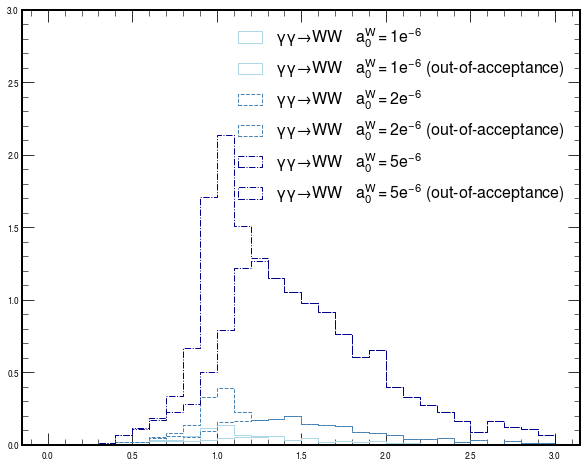

In [67]:
label_ = "GGToWW-AQGC-A0W5e-6"
# label_WW_ = "_nom"
label_WW_ = "_jes_up"

fig = plt.figure( figsize=(10,8) )

colors_ = [ "lightblue", "steelblue", "darkblue" ]
linestyles_ = [ "-", "--", "-." ]
for idx_, label_ in enumerate( labels_signals ):
    plt.hist( df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "R_MWW_MX" + label_WW_ ], weights=weights_sig_plus_mix_2protons[ label_ ],
              histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=labels_samples[ label_ ],
              bins=30, range=(0.,3.) )
    plt.hist( df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat_skip_sig[ label_ ][ "R_MWW_MX" + label_WW_ ], weights=weights_sig_plus_mix_categories_concat_skip_sig[ label_ ],
              histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=( labels_samples[ label_ ] + " (out-of-acceptance)" ),
              bins=30, range=(0.,3.) )
plt.legend( loc='best', fontsize=16 )
    
plt.ylim( (0.,3.) )

if save_figures:
    plt.savefig( "plots/Ratio_MWW_MX_signals_mix.pdf", bbox_inches='tight' )
    plt.savefig( "plots/Ratio_MWW_MX_signals_mix.png", bbox_inches='tight' )

2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix


(0.0, 3.0)

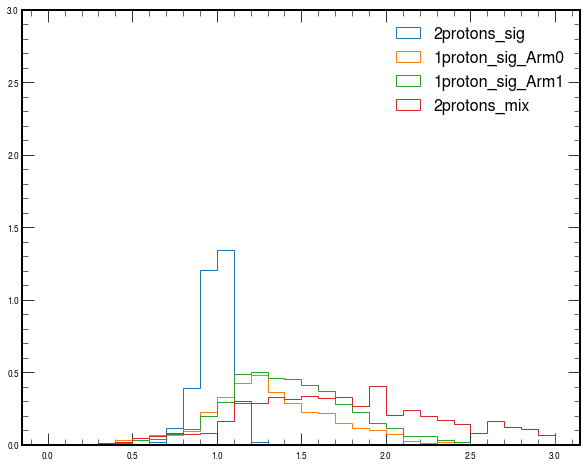

In [68]:
# label_ = "GGToWW-AQGC-A0W5e-6"

fig = plt.figure( figsize=(10,8) )
for key_ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ]:
    print ( key_ )
    df_selected_events__ = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ key_ ]
    plt.hist( df_selected_events__[ "R_MWW_MX" + label_WW_ ], weights=weights_sig_plus_mix_categories[ label_ ][ key_ ],
              histtype='step', label=key_,
              bins=30, range=(0.,3.) )
plt.legend( loc='best', fontsize=16 )
plt.ylim( (0.,3.) )

2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix


(0.0, 3.0)

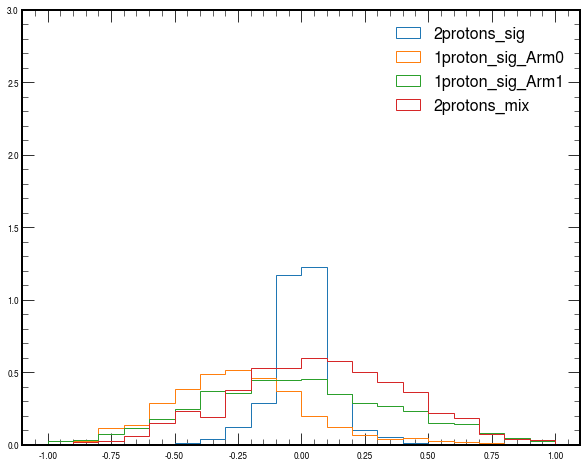

In [69]:
# label_ = "GGToWW-AQGC-A0W5e-6"

fig = plt.figure( figsize=(10,8) )
for key_ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ]:
    print ( key_ )
    df_selected_events__ = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ key_ ]
    plt.hist( df_selected_events__[ "Diff_YWW_YX" + label_WW_ ], weights=weights_sig_plus_mix_categories[ label_ ][ key_ ],
              histtype='step', label=key_,
              bins=20, range=(-1.,1.) )
plt.legend( loc='best', fontsize=16 )
plt.ylim( (0.,3.) )

In [70]:
# label_ = "GGToWW-AQGC-A0W5e-6"
# fig = plt.figure( figsize=(12,10) )
# for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ]:
#     print ( key_ )
#     df_selected_events__ = df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ][ key_ ]
#     plt.hist( df_selected_events__[ "ratioMWW_MX" ], weights=weights_out_acceptance_misreconstructed[ label_ ][ key_ ],
#               histtype='step', label=key_,
#               bins=20, range=(0.,2.) )
# plt.legend( loc='best', fontsize=16 )

In [71]:
# fig = plt.figure( figsize=(10,8) )

# colors_ = [ "lightblue", "steelblue", "darkblue" ]
# linestyles_ = [ "-", "--", "-." ]
# for idx_, label_ in enumerate( labels_signals ):
#     plt.hist( df_signals_protons_multiRP_events[ label_ ][ "ratioMWW_MX" ], weights=weights_mc[ label_ ],
#               histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=labels_samples[ label_ ],
#               bins=30, range=(0.,3.) )
#     plt.hist( df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events_concat[ label_ ][ "ratioMWW_MX" ],
#               weights=weights_out_acceptance_misreconstructed_concat[ label_ ],
#               histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=( labels_samples[ label_ ] + " (out-of-acceptance)" ),
#               bins=30, range=(0.,3.) )


# plt.legend( loc='best', fontsize=16 )
    
# plt.ylim( (0.,3.) )

# if save_figures:
#     plt.savefig( "plots/Ratio_MWW_MX_signals.pdf", bbox_inches='tight' )
#     plt.savefig( "plots/Ratio_MWW_MX_signals.png", bbox_inches='tight' )